# Sumário

1. [Introdução](#1.-Introdução)
2. [Importação das Bibliotecas](#2.-Importação-das-Bibliotecas)
3. [Importação dos Dados](#3.-Importação-dos-Dados)
4. [Análise Exploratória dos Dados (EDA)](#4.-Análise-Exploratória-dos-Dados-(EDA))  
   4.1 [Conjunto de dados](#4.1-Conjunto-de-dados)  
   4.2 [Distribuição](#4.2-Distribuição)  
   4.3 [Gráficos das séries temporais](#4.3-Gráficos-das-séries-temporais)  
   4.4 [Matriz de Correlação](#4.4-Matriz-de-Correlação)  
   4.5 [Gráfico de Barras de Correlação](#4.5-Gráfico-de-Barras-de-Correlação)  
   4.6 [Gráficos de Box Plots](#4.6-Gráficos-de-Box-Plots)  
   4.6 [Gráficos de Dispersão](#4.7-Gráficos-de-Dispersão)  
5. [Seleção de Features](#5.-Seleção-de-Features)  
6. [Análise da Target](#6.-Análise-da-Target)  
    6.1 [Teste de Estacionariedade](#6.1-Teste-de-Estacionariedade)  
    6.2 [Tendência e Sazonalidade](#6.2-Tendência-e-Sazonalidade)  
    6.3 [Função de Autocorrelação (ACF)](#6.3-Função-de-Autocorrelação-(ACF))  
    6.4 [Função de Autocorrelação Parcial (PACF)](#6.4-Função-de-Autocorrelação-Parcial-(PACF))  
7. [Preparação dos Dados](#7.-Preparação-dos-Dados)  
8. [Treinamento dos Modelos](#8.-Treinamento-dos-Modelos)  
    8.1 [ARIMA-SARIMA-SARIMAX](#8.1-ARIMA-SARIMA-SARIMAX)  
    8.2 [Auto ARIMA](#8.2-Auto-ARIMA)  
    8.3 [Prophet](#8.3-Prophet)  
9. [Teste e Projeções dos Modelos](#9.-Teste-e-Projeções-dos-Modelos)   
    9.1 [SARIMA](#9.1-SARIMA)  
    9.2 [SARIMAX](#9.2-SARIMAX)  
    9.3 [Prophet](#9.3-Prophet)  
10. [Conclusão](#10.-Conclusão)  

# 1. Introdução

## Sobre os dados

Este arquivo contém dados meteorológicos coletados na cidade de Delhi <b> (hemisfério norte!) </b> no período de 4 meses (2017). Pode ser usado para fins de previsão. Este é um conjunto de dados puramente acadêmico e foi desenvolvido como parte do curso de Análise de Dados de 2019.

### Colunas

- **meantemp** ➔ Temperatura média calculada a partir de múltiplos intervalos de 3 horas em um dia.
- **humidity** ➔ Valor da umidade para o dia (unidades são gramas de vapor d'água por metro cúbico de volume de ar).
- **wind_speed** ➔ Velocidade do vento medida em km/h.
- **meanpressure** ➔ Leitura da pressão atmosférica (medida em atm).

# 2. Importação das Bibliotecas

Importando as bibliotecas e recursos necessários.

In [1]:
# Dados
import pandas as pd

# Matemática
import numpy as np

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Gráficos de autocorrelação
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Gráfico de resíduos
from statsmodels.graphics.gofplots import qqplot

# Testes estatísticos
from statsmodels.tsa.stattools import adfuller, kpss

# Teste de tendência e sazonalidade
from statsmodels.tsa.seasonal import STL

# Métricas de erro
from sklearn.metrics import mean_squared_error, r2_score

# Modelo SARIMAX
import pmdarima as pm
from pmdarima.arima import ARIMA

# Modelo Prophet
from prophet import Prophet

# Exportação do modelo
from joblib import dump, load

# 3. Importação dos Dados

Importando os arquivos com os dados de treino e teste.

In [2]:
df = pd.read_csv(r'DailyDelhiClimateTrain.csv', 
                 parse_dates=['date'], # Transformando a coluna para datetime
                 index_col=['date'])

df_teste = pd.read_csv(r'DailyDelhiClimateTest.csv', 
                       parse_dates=['date'],
                       index_col=['date'])

Renomeando as colunas:

In [3]:
df.index.name = 'data'
df_teste.index.name = 'data'

df.rename(mapper={'meantemp': 'temperatura_media', 
'humidity': 'humidade', 
'wind_speed': 'velocidade_do_vento',
'meanpressure': 'pressao_media'}, axis = 1, inplace = True)

df_teste.rename(mapper={'meantemp': 'temperatura_media', 
'humidity': 'humidade', 
'wind_speed': 'velocidade_do_vento',
'meanpressure': 'pressao_media'}, axis = 1, inplace = True)

Criando novas variáveis para o EDA.

In [189]:
df["ano"] = df.index.year
df["mes"] = df.index.month 

# Função para categorizar as estações do ano no hemisfério norte
def obter_estacao(dia):
    ano = dia.year
    if pd.Timestamp(ano, 12, 21) <= dia or dia < pd.Timestamp(ano, 3, 21):
        return 1  # Inverno (21 de dezembro a 20 de março)
    elif pd.Timestamp(ano, 3, 21) <= dia < pd.Timestamp(ano, 6, 21):
        return 3  # Primavera (21 de março a 20 de junho)
    elif pd.Timestamp(ano, 6, 21) <= dia < pd.Timestamp(ano, 9, 23):
        return 4  # Verão (21 de junho a 22 de setembro)
    elif pd.Timestamp(ano, 9, 23) <= dia < pd.Timestamp(ano, 12, 21):
        return 2  # Outono (23 de setembro a 20 de dezembro)

# Aplicando a função para criar a nova coluna de estação
df["estacao"] = df.index.map(obter_estacao)
df_teste["estacao"] = df_teste.index.map(obter_estacao)

# 4. Análise Exploratória dos Dados (EDA)

Explorando, visualizando e aprofundando o entendimento sobre os dados.

## 4.1 Conjunto de dados

In [5]:
df.shape

(1462, 7)

In [6]:
df

,temperatura_media,humidade,velocidade_do_vento,pressao_media,ano,mes,estacao
data,,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,2013,1,1
2013-01-02,7.400000,92.000000,2.980000,1017.800000,2013,1,1
2013-01-03,7.166667,87.000000,4.633333,1018.666667,2013,1,1
2013-01-04,8.666667,71.333333,1.233333,1017.166667,2013,1,1
2013-01-05,6.000000,86.833333,3.700000,1016.500000,2013,1,1
...,...,...,...,...,...,...,...
2016-12-28,17.217391,68.043478,3.547826,1015.565217,2016,12,1
2016-12-29,15.238095,87.857143,6.000000,1016.904762,2016,12,1
2016-12-30,14.095238,89.666667,6.266667,1017.904762,2016,12,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   temperatura_media    1462 non-null   float64
 1   humidade             1462 non-null   float64
 2   velocidade_do_vento  1462 non-null   float64
 3   pressao_media        1462 non-null   float64
 4   ano                  1462 non-null   int64  
 5   mes                  1462 non-null   int64  
 6   estacao              1462 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 91.4 KB


In [8]:
df.isna().sum()

temperatura_media      0
humidade               0
velocidade_do_vento    0
pressao_media          0
ano                    0
mes                    0
estacao                0
dtype: int64

## 4.2 Distribuição

In [9]:
df.describe().style.background_gradient(cmap = 'Blues')

,temperatura_media,humidade,velocidade_do_vento,pressao_media,ano,mes,estacao
count,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548,2014.502736,6.519152,2.518468
std,7.348103,16.769652,4.561602,180.231668,1.120248,3.451727,1.122540
min,6.000000,13.428571,0.000000,-3.041667,2013.000000,1.000000,1.000000
25%,18.857143,50.375000,3.475000,1001.580357,2014.000000,4.000000,2.000000
50%,27.714286,62.625000,6.221667,1008.563492,2015.000000,7.000000,3.000000
75%,31.305804,72.218750,9.238235,1014.944901,2016.000000,10.000000,4.000000
max,38.714286,100.000000,42.220000,7679.333333,2017.000000,12.000000,4.000000


## 4.3 Gráficos das séries temporais

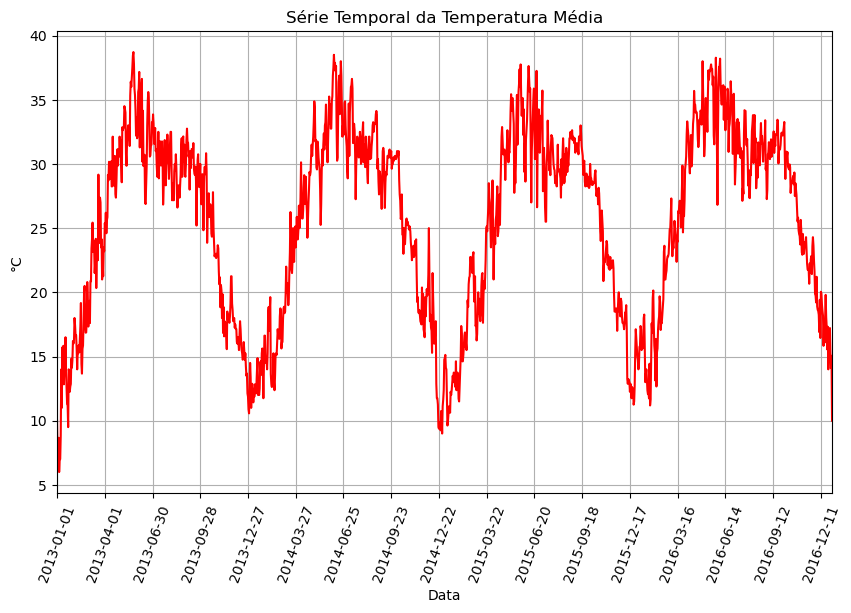

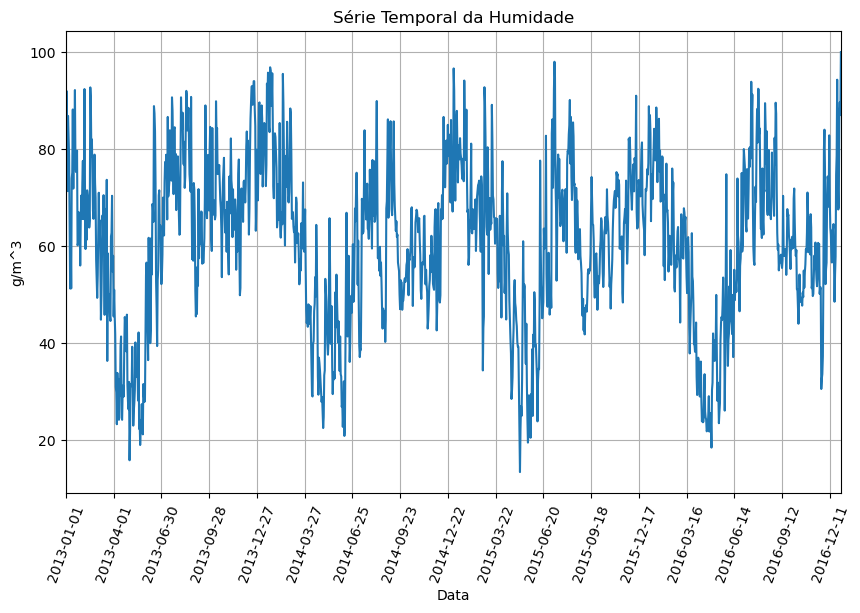

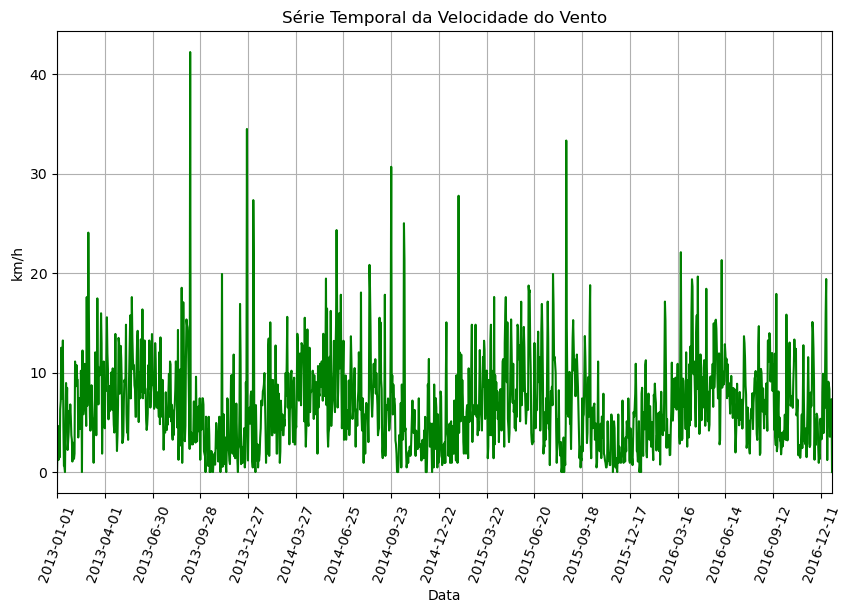

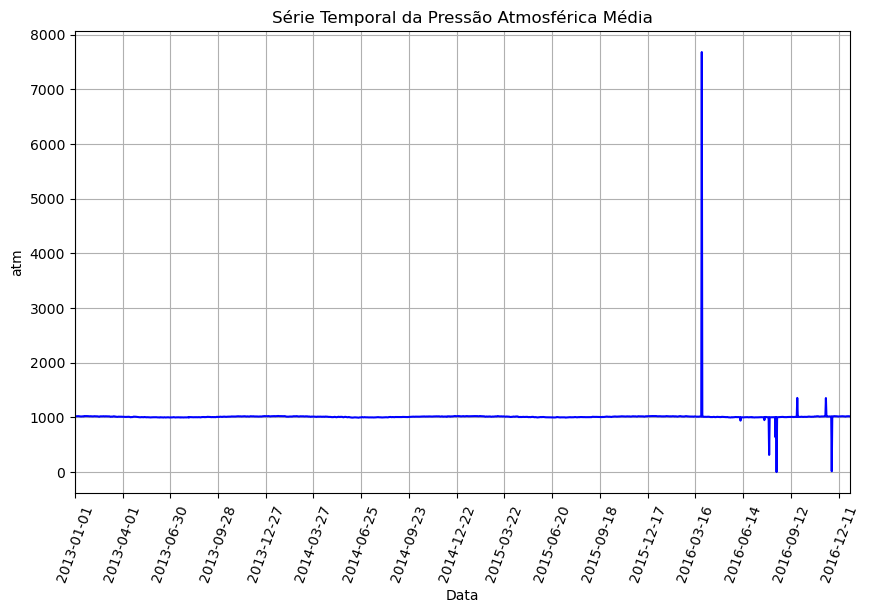

In [10]:
# Definindo as datas do eixo X a cada 90 dias
ticks = []
for i in range(len(df.index)):
    if i%90 == 0:
        ticks.append(df.index[i])

# Grafico da temperatura
plt.figure(figsize=(10, 6))
plt.plot(df['temperatura_media'], color='red')
plt.title('Série Temporal da Temperatura Média')
plt.xlabel('Data')
plt.ylabel('°C')
plt.xticks(ticks = ticks,rotation='70')
plt.xlim(df.index.min(),df.index.max())
plt.grid(True)
plt.show()

# Grafico da humidade
plt.figure(figsize=(10, 6))
plt.plot(df['humidade'])
plt.title('Série Temporal da Humidade')
plt.xlabel('Data')
plt.ylabel('g/m^3')
plt.xticks(ticks = ticks,rotation='70')
plt.xlim(df.index.min(),df.index.max())
plt.grid(True)
plt.show()

# Grafico da velocidade do vento
plt.figure(figsize=(10, 6))
plt.plot(df['velocidade_do_vento'], color='green')
plt.title('Série Temporal da Velocidade do Vento')
plt.xlabel('Data')
plt.ylabel('km/h')
plt.xticks(ticks = ticks,rotation='70')
plt.xlim(df.index.min(),df.index.max())
plt.grid(True)
plt.show()

# Grafico da pressão
plt.figure(figsize=(10, 6))
plt.plot(df['pressao_media'], color='blue')
plt.title('Série Temporal da Pressão Atmosférica Média')
plt.xlabel('Data')
plt.ylabel('atm')
plt.xticks(ticks = ticks,rotation='70')
plt.xlim(df.index.min(),df.index.max())
plt.grid(True)
plt.show()

## 4.4 Matriz de Correlação 

Matriz de correlação linear entre as séries.

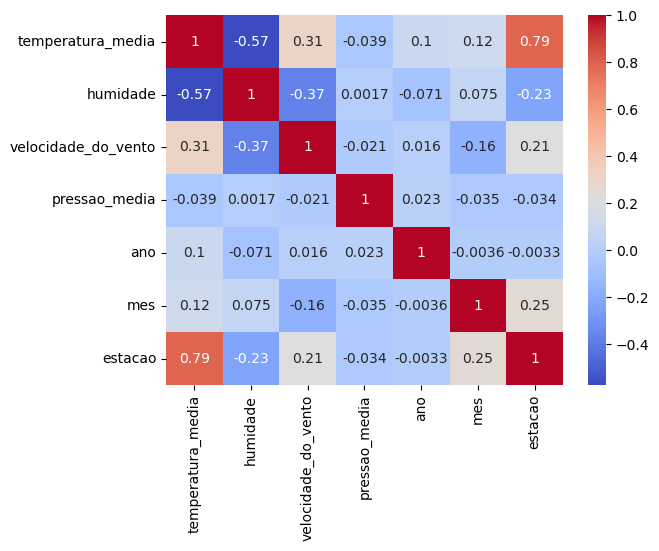

In [11]:
sns.heatmap(df.corr(), cmap='coolwarm', annot=True)
plt.show()

## 4.5 Gráfico de Barras de Correlação 

Mostra a correlação linear entre as variáveis e a temperatura média.

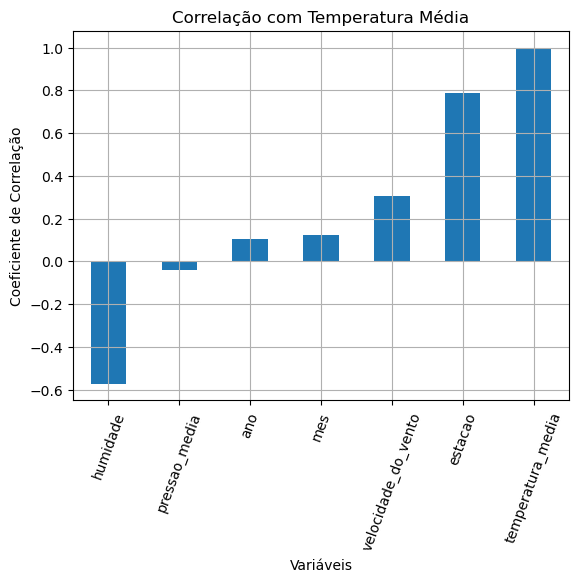

In [12]:
df.corr().temperatura_media.sort_values().plot(kind='bar')
plt.xticks(rotation='70')
plt.title('Correlação com Temperatura Média')
plt.ylabel('Coeficiente de Correlação')
plt.xlabel('Variáveis')
plt.grid(True)
plt.show()

## 4.6 Gráficos de Box Plots

#### Humidade

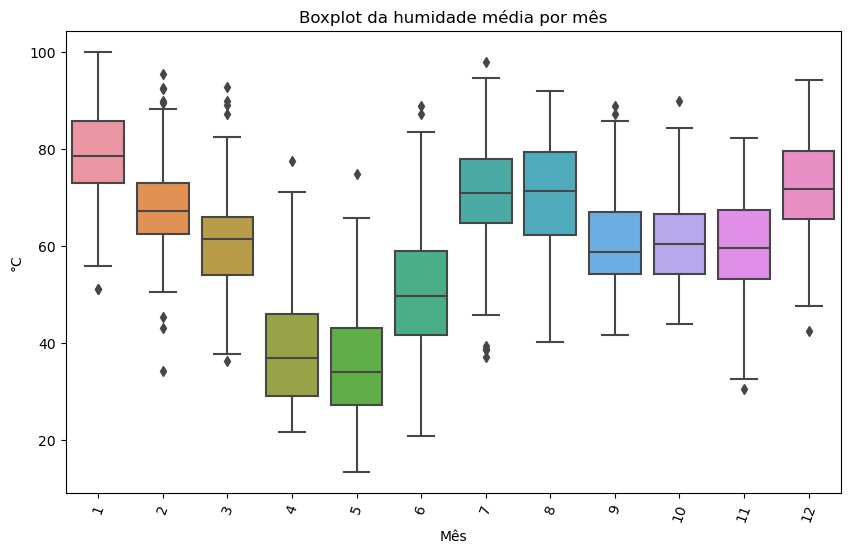

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='humidade', x='mes', data=df)
plt.title(f'Boxplot da humidade média por mês')
plt.xlabel('Mês')
plt.ylabel('°C')
plt.xticks(rotation=70)
plt.show()

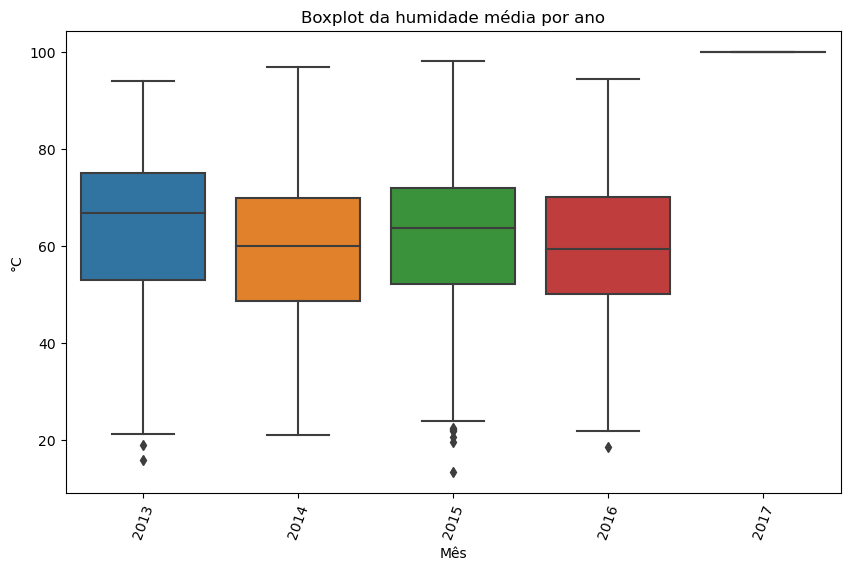

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='humidade', x='ano', data=df)
plt.title(f'Boxplot da humidade média por ano')
plt.xlabel('Mês')
plt.ylabel('°C')
plt.xticks(rotation=70)
plt.show()

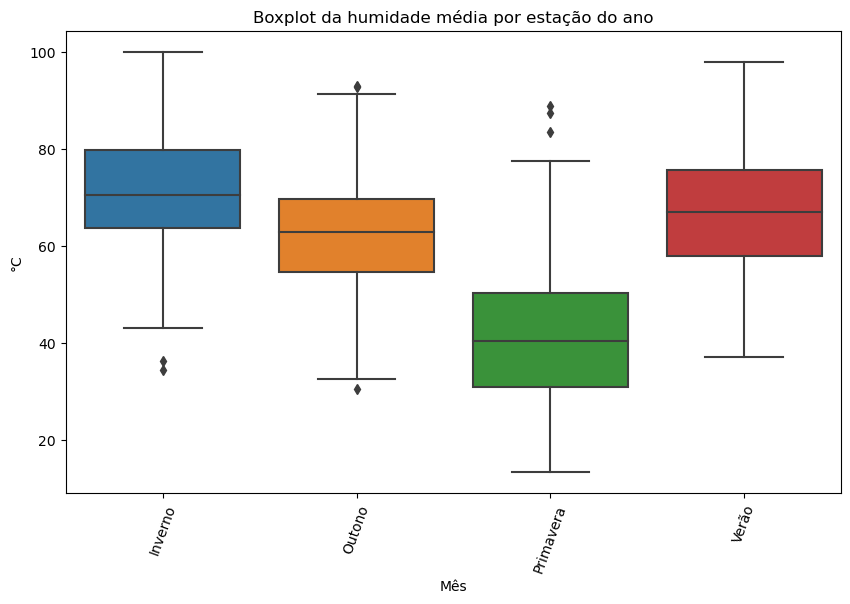

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='humidade', x='estacao', data=df)
plt.title(f'Boxplot da humidade média por estação do ano')
plt.xlabel('Mês')
plt.ylabel('°C')
plt.xticks(rotation=70)
plt.xticks(ticks=[0, 1, 2, 3], labels=['Inverno', 'Outono', 'Primavera', 'Verão'], rotation=70)
plt.show()

#### Velocidade do vento

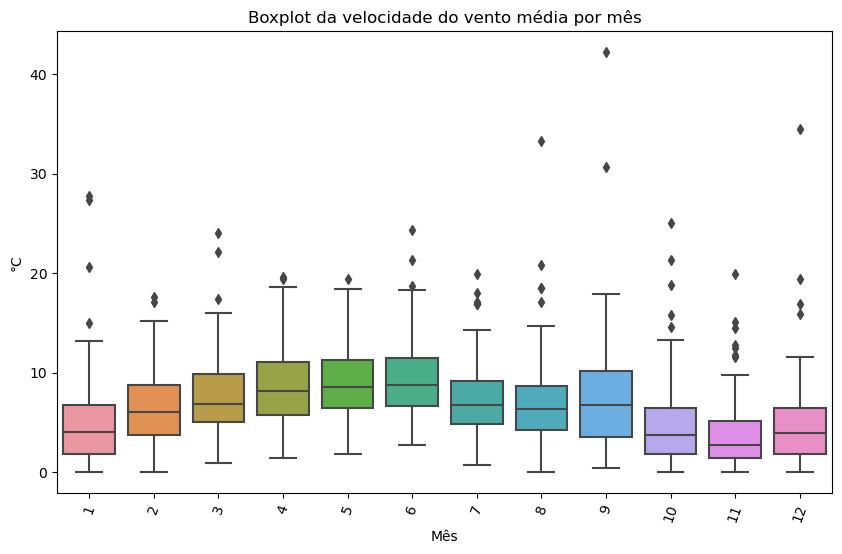

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='velocidade_do_vento', x='mes', data=df)
plt.title(f'Boxplot da velocidade do vento média por mês')
plt.xlabel('Mês')
plt.ylabel('°C')
plt.xticks(rotation=70)
plt.show()

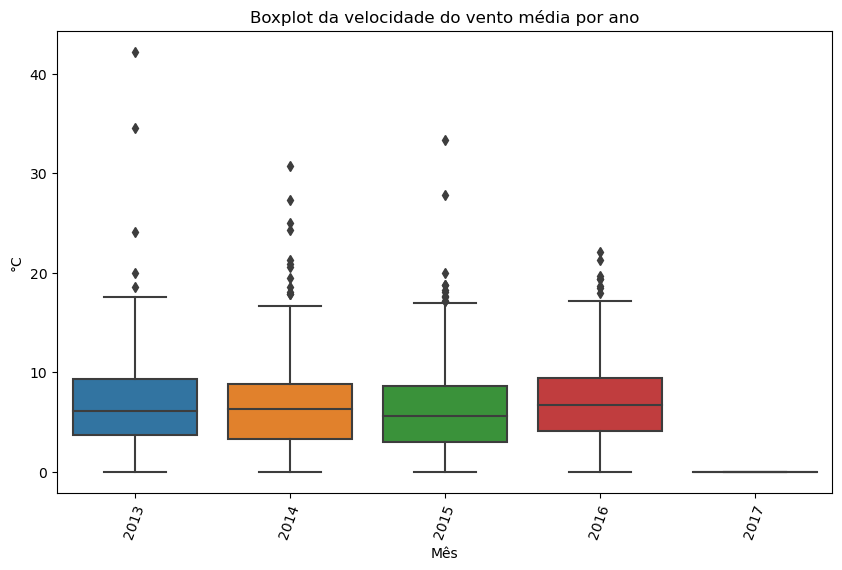

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='velocidade_do_vento', x='ano', data=df)
plt.title(f'Boxplot da velocidade do vento média por ano')
plt.xlabel('Mês')
plt.ylabel('°C')
plt.xticks(rotation=70)
plt.show()

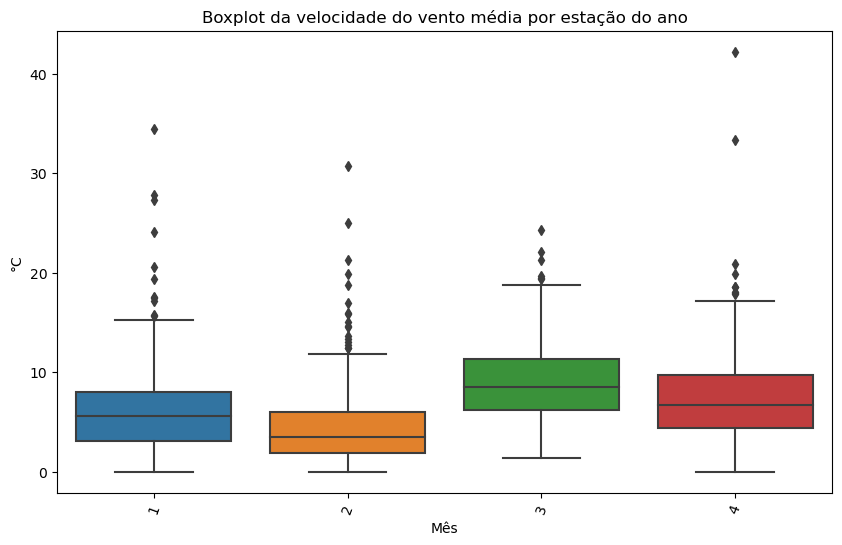

In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='velocidade_do_vento', x='estacao', data=df)
plt.title(f'Boxplot da velocidade do vento média por estação do ano')
plt.xlabel('Mês')
plt.ylabel('°C')
plt.xticks(rotation=70)
plt.show()

#### Pressão atmosférica

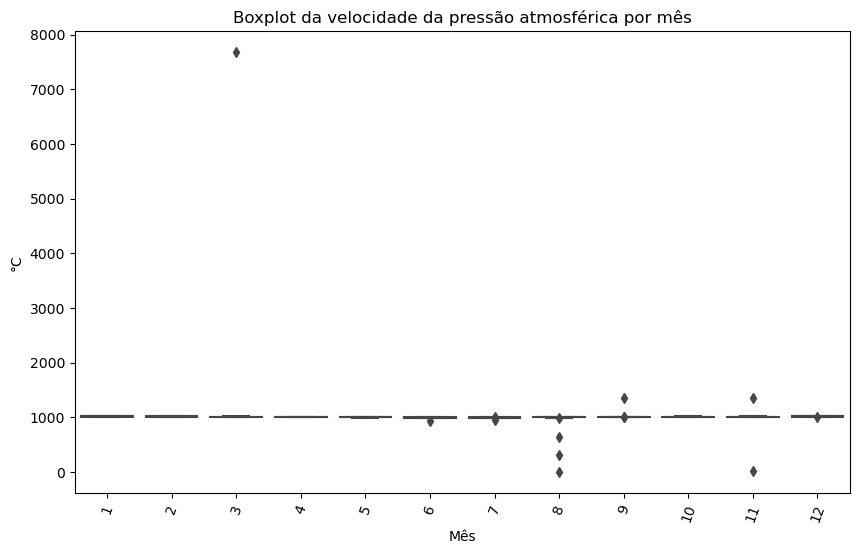

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='pressao_media', x='mes', data=df)
plt.title(f'Boxplot da velocidade da pressão atmosférica por mês')
plt.xlabel('Mês')
plt.ylabel('°C')
plt.xticks(rotation=70)
plt.show()

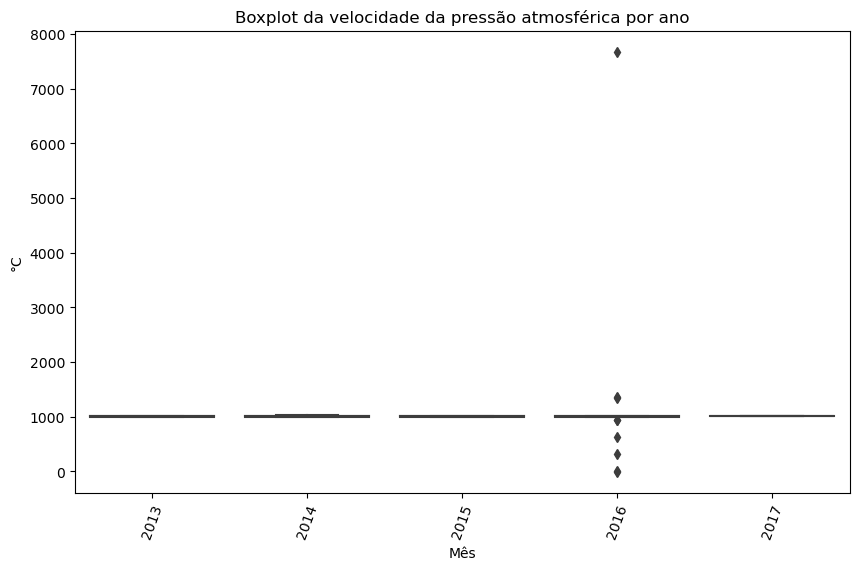

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='pressao_media', x='ano', data=df)
plt.title(f'Boxplot da velocidade da pressão atmosférica por ano')
plt.xlabel('Mês')
plt.ylabel('°C')
plt.xticks(rotation=70)
plt.show()

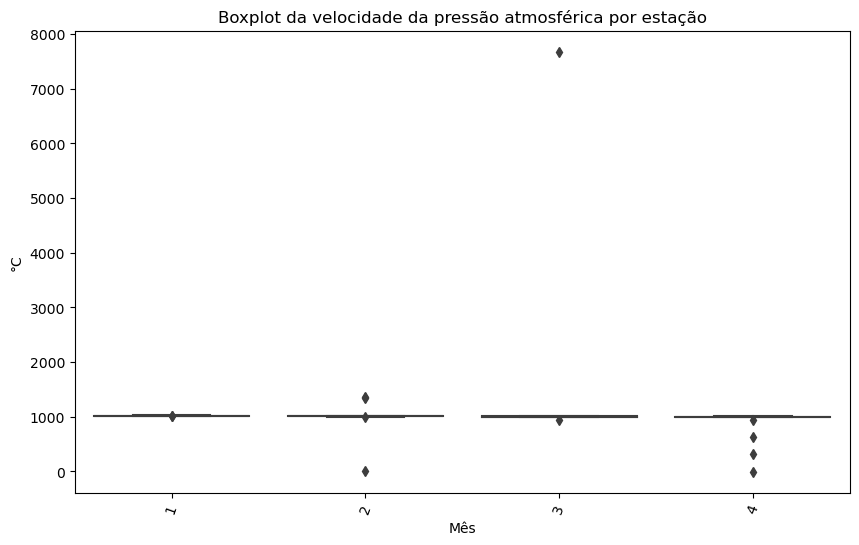

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='pressao_media', x='estacao', data=df)
plt.title(f'Boxplot da velocidade da pressão atmosférica por estação')
plt.xlabel('Mês')
plt.ylabel('°C')
plt.xticks(rotation=70)
plt.show()

#### Temperatura

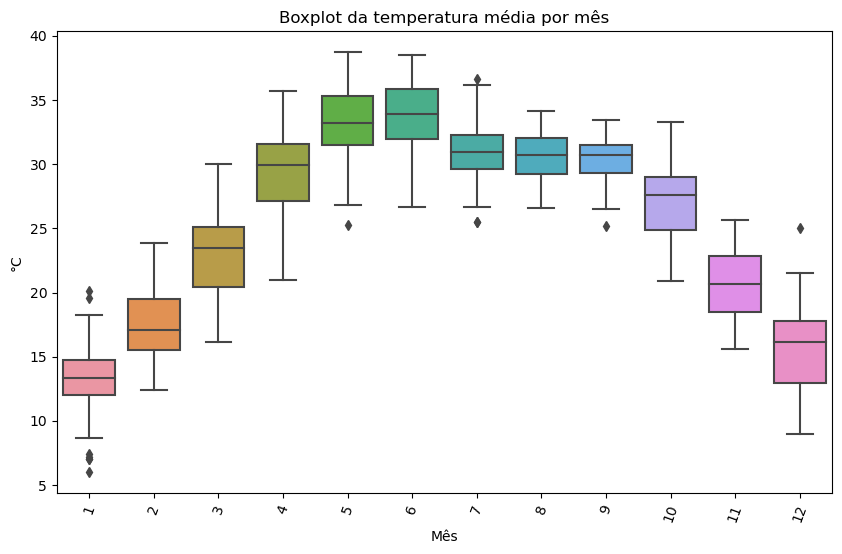

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='temperatura_media', x='mes', data=df)
plt.title(f'Boxplot da temperatura média por mês')
plt.xlabel('Mês')
plt.ylabel('°C')
plt.xticks(rotation=70)
plt.show()

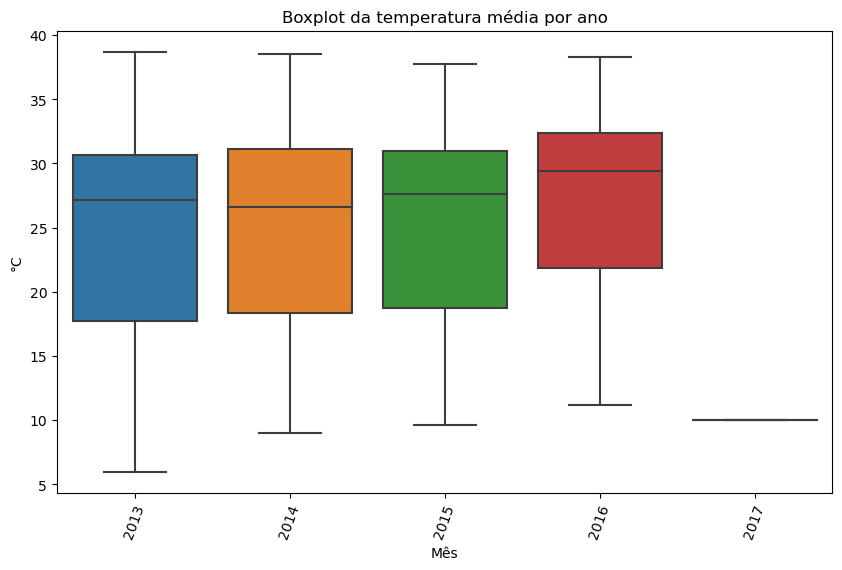

In [23]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='temperatura_media', x='ano', data=df)
plt.title(f'Boxplot da temperatura média por ano')
plt.xlabel('Mês')
plt.ylabel('°C')
plt.xticks(rotation=70)
plt.show()

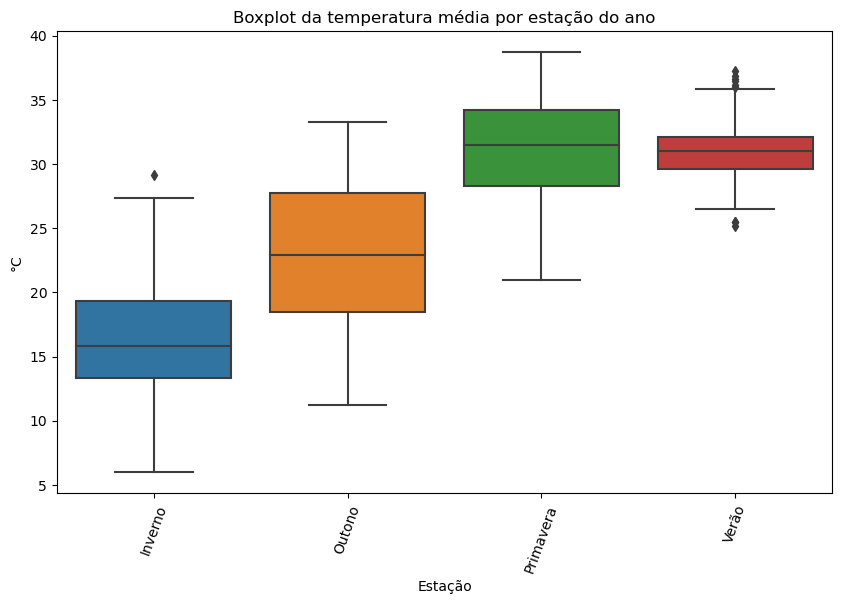

In [24]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='temperatura_media', x='estacao', data=df)
plt.title(f'Boxplot da temperatura média por estação do ano')
plt.xlabel('Estação')
plt.ylabel('°C')
plt.xticks(ticks=[0, 1, 2, 3], labels=['Inverno', 'Outono', 'Primavera', 'Verão'], rotation=70)
plt.show()

## 4.7 Gráficos de Dispersão

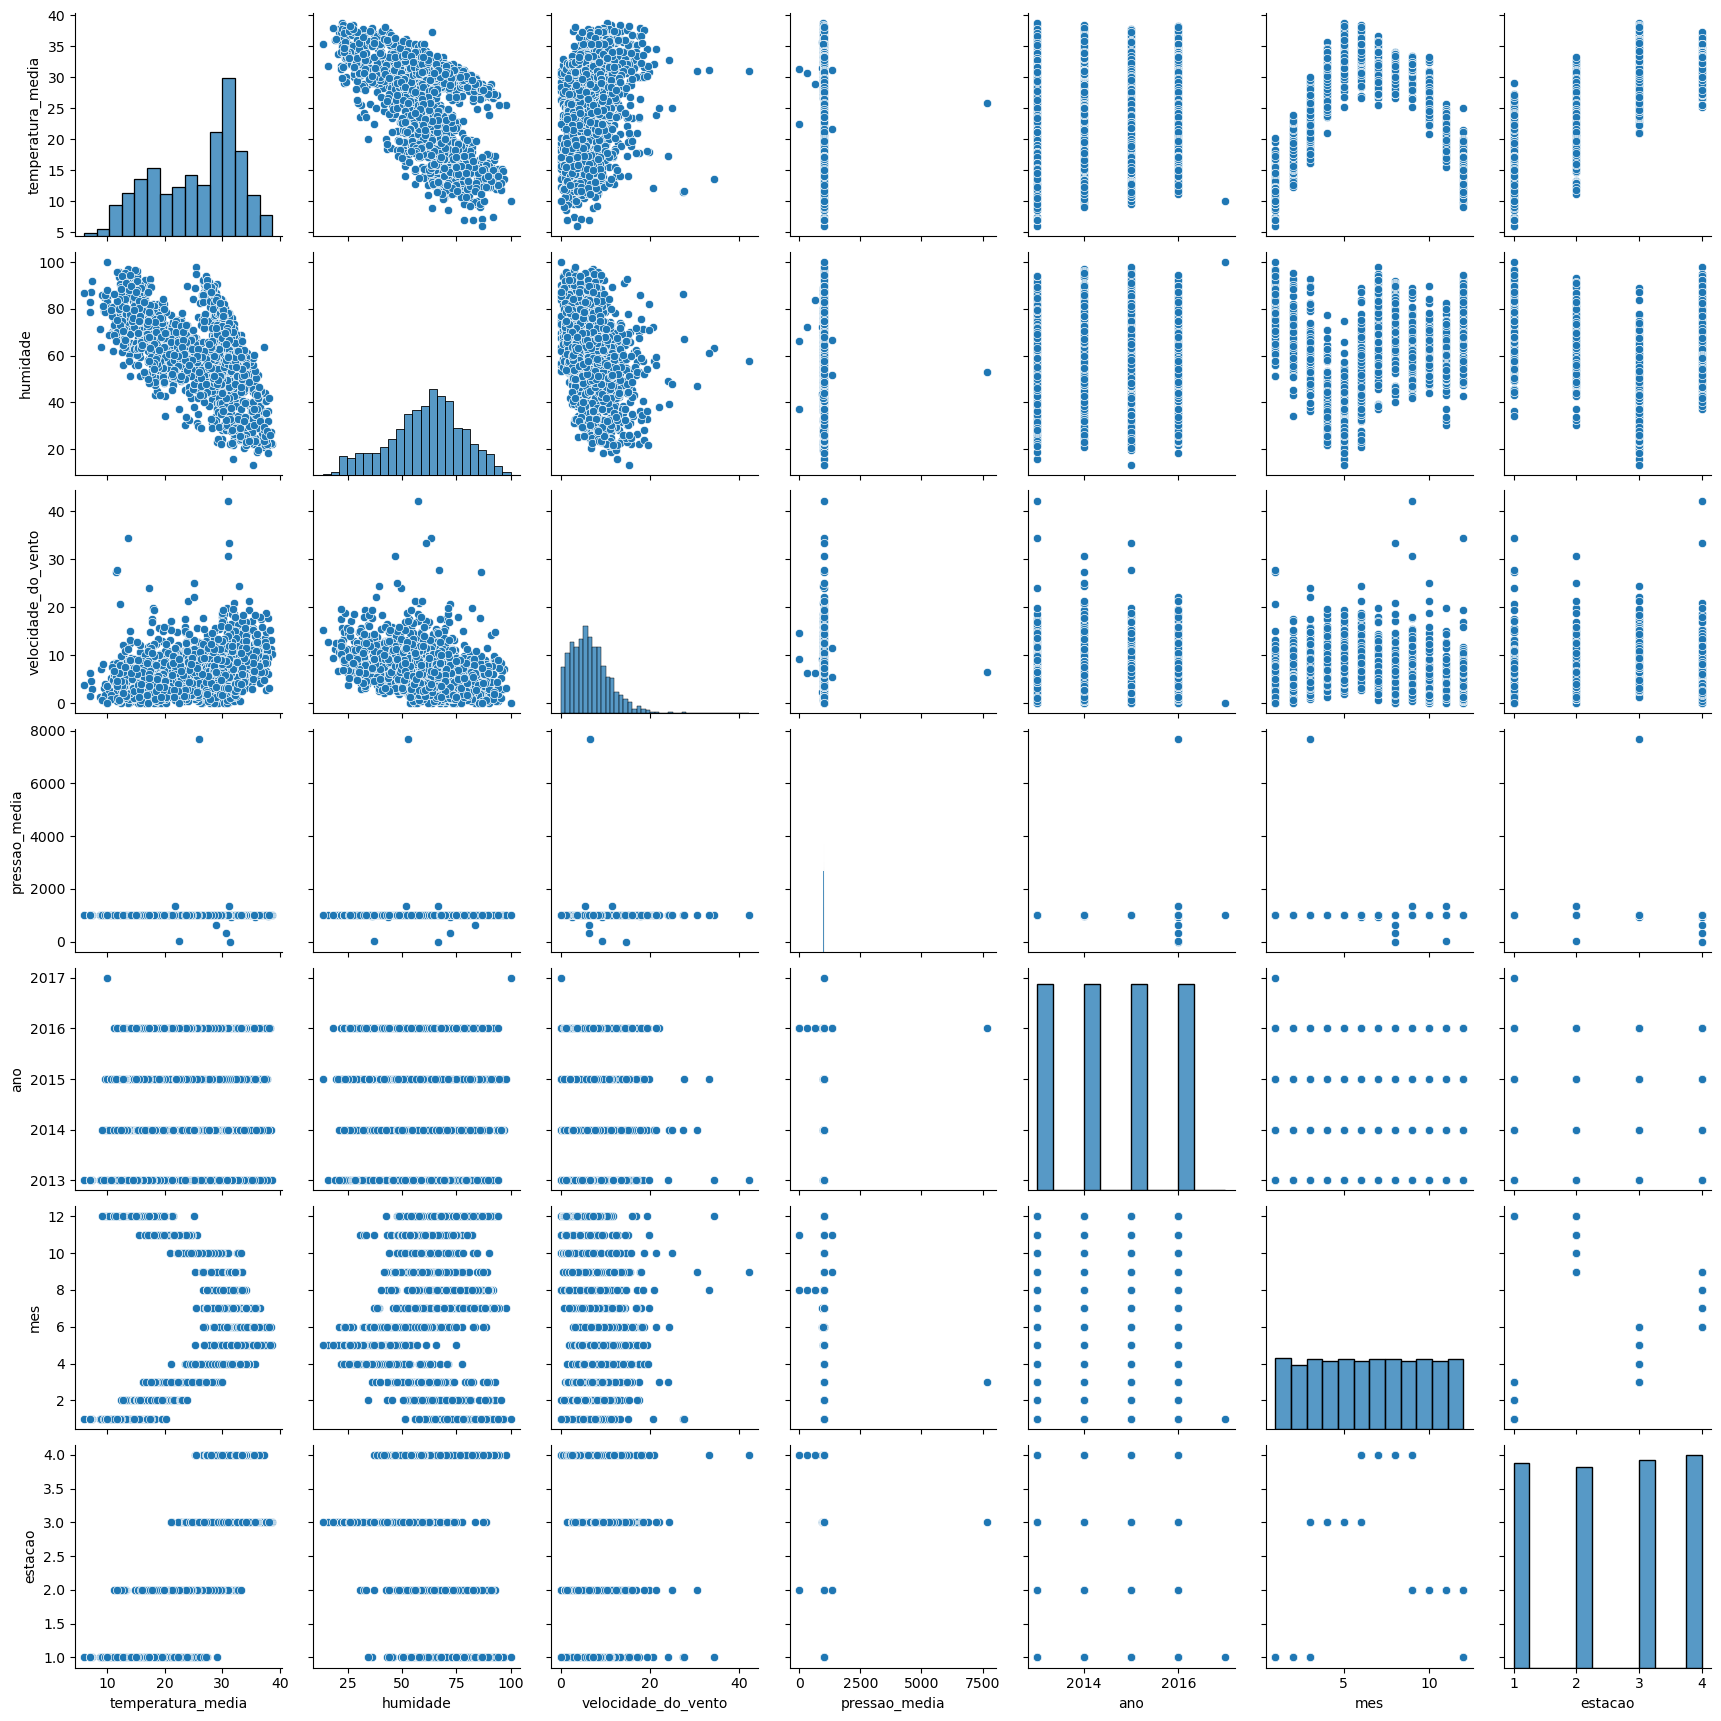

In [25]:
sns.pairplot(df)
plt.show()

# 5. Seleção de Features

Após essa análise, é possível afirmar que a pressão atmosférica, que sempre estará próxima de 1 atm, salvo erros de medição que aparentemente ocorreram em 2016, é uma váriavel descorrelacionada da temperatura e, portanto, estarei removendo-a e mantendo apenas as variáveis explicativas de humidade e velocidade do vento.

In [26]:
df.drop(['pressao_media','ano', 'mes'], axis=1, inplace=True)

# 6. Análise da Target

## 6.1 Teste de Estacionariedade

Avaliando a estacionariedade da série de temperatura média. Utilizando os testes estatísticos Augmented Dickey Fuller (ADF) e Kwiatkowski-Phillips-Schmidt-Shin (KPSS).

In [27]:
def teste_adf(serie):
    ''' Teste Augmented Dickey Fuller (ADF)
    
    I. Hipótese Nula: A série não estacionária.
    II. Hipótese Alternativa: Série estacionária.
    
    '''
    print("Resultados do teste Dickey-Fuller:")
    dftest = adfuller(serie, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Teste estatistico",
            "p-valor",
            "Quantidade de lags usados",
            "Número de observações usados",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput[f"Valor crítico ({key})"] = value
    print(dfoutput)
    
def teste_kpss(serie):
    '''  Kwiatkowski-Phillips-Schmidt-Shin (KPSS)
    
    I. Hipótese Nula: A série estacionária.
    II. Hipótese Alternativa: Série não estacionária.
    
    '''
    print("Resultados do teste KPSS:")
    kpsstest = kpss(serie, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Teste estatistico", "p-valor", "Lags usados"]
    )
    for key, value in kpsstest[3].items():
        kpss_output[f"Valor crítico ({key})"] = value
    print(kpss_output)

Queremos prever a temperatura, então avaliaremos se estatisticamente essa série é estacionária.

#### Teste Augmented Dickey Fuller ("ADF")

    I. Hipótese nula: A série tem raiz unitária (Série não estacionária).
    II. Hipótese alternativa: A série não tem raiz unitária. (Série estacionária).

In [28]:
teste_adf(df.temperatura_media)

Resultados do teste Dickey-Fuller:
Teste estatistico                 -2.021069
p-valor                            0.277412
Quantidade de lags usados         10.000000
Número de observações usados    1451.000000
Valor crítico (1%)                -3.434865
Valor crítico (5%)                -2.863534
Valor crítico (10%)               -2.567832
dtype: float64


<b> Conclusão ADF: </b> p-valor > 5% e, portanto, não se rejeita H0 => Série não estacionária.

#### Kwiatkowski-Phillips-Schmidt-Shin ("KPSS")

    I. Hipótese nula: O processo é estacionário em termos de tendência (Série estacionária).
    II. Hipótese alternativa: A série tem uma raiz unitária. (Série não estacionária).

In [29]:
teste_kpss(df.temperatura_media)

Resultados do teste KPSS:
Teste estatistico        0.187864
p-valor                  0.100000
Lags usados             25.000000
Valor crítico (10%)      0.347000
Valor crítico (5%)       0.463000
Valor crítico (2.5%)     0.574000
Valor crítico (1%)       0.739000
dtype: float64


C:\Users\Gamer\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


<b> Conclusão KPSS: </b> p-valor > 5% e, portanto, não se rejeita H0 => Série estacionária.

<b> Casos Possíveis: </b>  
* Caso 1: Ambos os testes concluem que a série não é estacionária - A série não é estacionária.  
* Caso 2: Ambos os testes concluem que a série é estacionária - A série é estacionária.  
* Caso 3: KPSS indica estacionariedade e ADF indica não estacionariedade - A série é estacionária de tendência. A tendência precisa ser removida para tornar a série estritamente estacionária. A série sem tendência é verificada quanto à estacionariedade.  
* Caso 4: KPSS indica não estacionariedade e ADF indica estacionariedade - A série é estacionária por diferença. A diferenciação deve ser usada para tornar a série estacionária. A série diferenciada é verificada quanto à estacionariedade.

<b> Conclusão Final: </b> A série da temperatura se enquadra no caso 3. Portanto, a série é estacionária de tendência. A tendência precisa ser removida para tornar a série estritamente estacionária.

## 6.2 Tendência e Sazonalidade

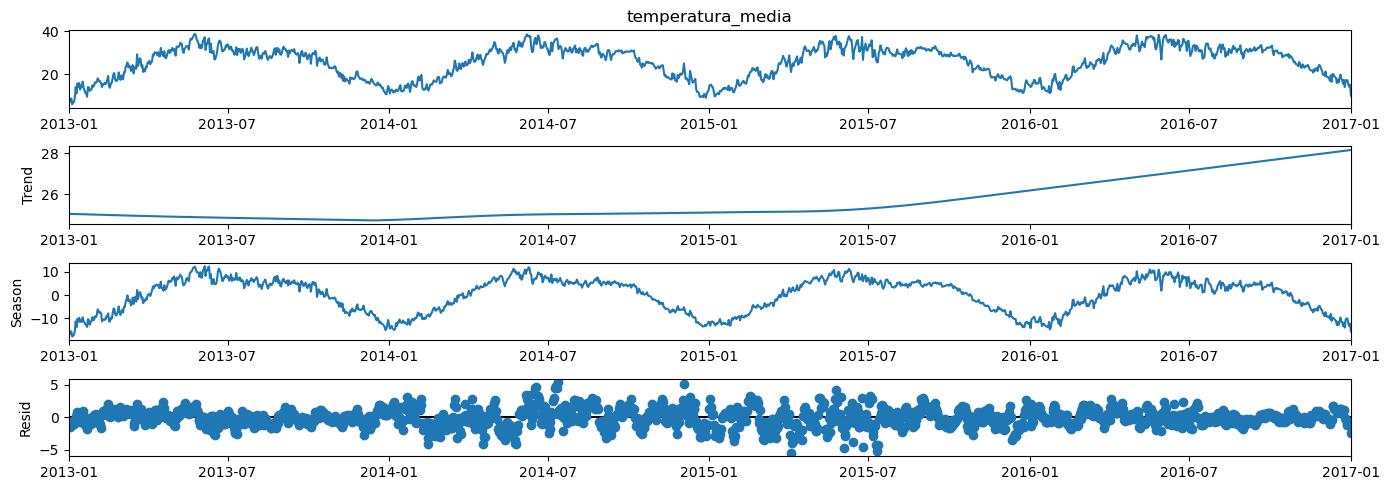

In [30]:
decomposicao = STL(df.temperatura_media, period=365).fit()
plt.rc("figure", figsize=(14,5))
decomposicao.plot()
plt.show()

#### Visualização dos resíduos

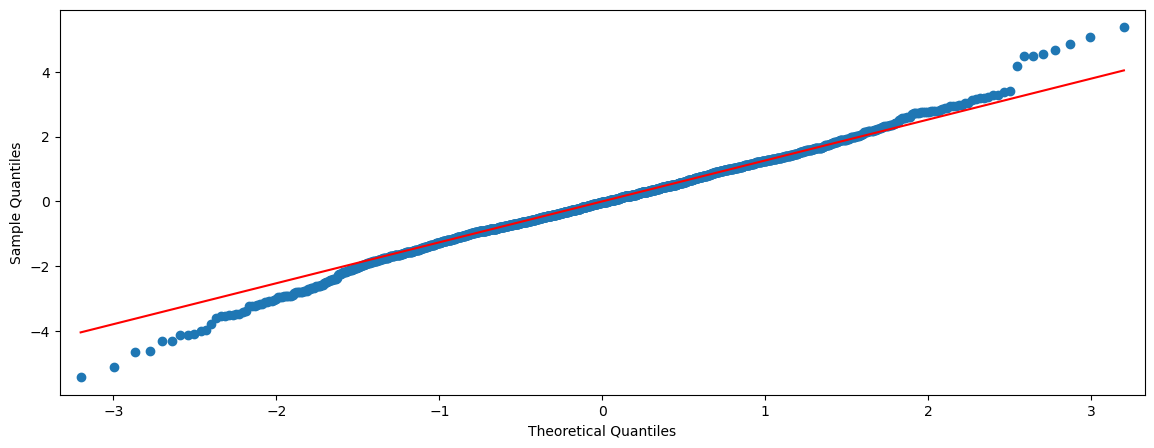

In [31]:
qqplot(decomposicao.resid, line = "q")
plt.show()

#### Sazonalidade média

In [32]:
df_sazonalidade = pd.DataFrame({'referencia': df.index, 'sazonalidade': decomposicao.seasonal})

df_sazonalidade['mes'] = pd.to_datetime(df_sazonalidade.referencia).dt.month
df_sazonalidade['ano'] = pd.to_datetime(df_sazonalidade.referencia).dt.year

sazonalidade_media_mes = df_sazonalidade.groupby('mes')['sazonalidade'].mean()
sazonalidade_media_ano = df_sazonalidade.groupby('ano')['sazonalidade'].mean()

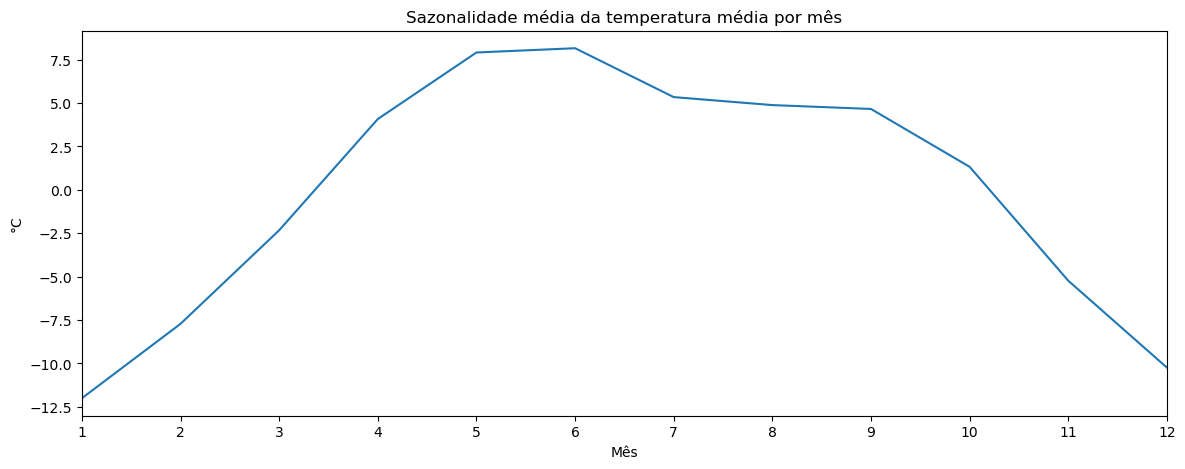

In [33]:
plt.figure(figsize = (14,5))
plt.plot(sazonalidade_media_mes.index, sazonalidade_media_mes.values)
plt.title('Sazonalidade média da temperatura média por mês')
plt.ylabel('°C')
plt.xlabel('Mês')
plt.xticks(range(1,13))
plt.xlim(1,12)
plt.show()

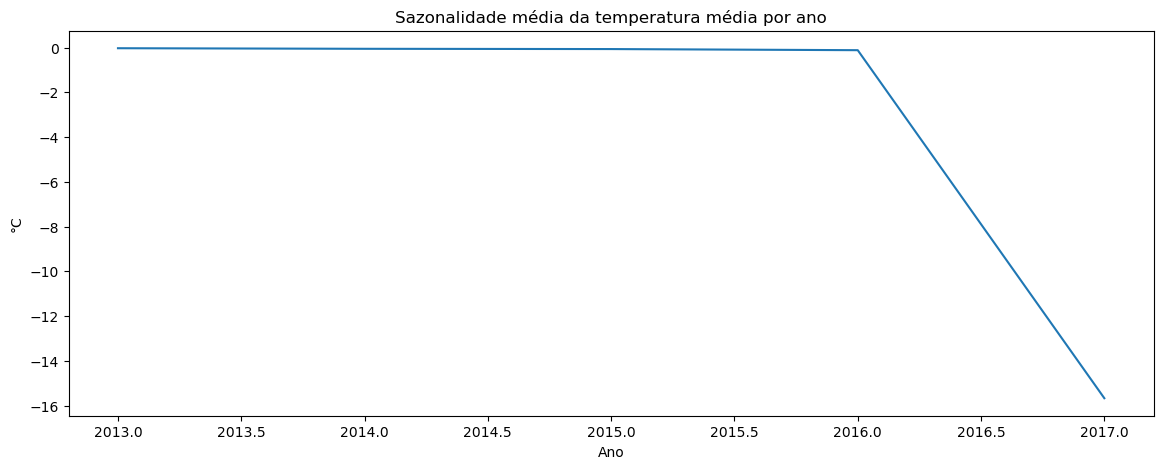

In [34]:
plt.figure(figsize = (14,5))
plt.plot(sazonalidade_media_ano.index, sazonalidade_media_ano.values)
plt.title('Sazonalidade média da temperatura média por ano')
plt.ylabel('°C')
plt.xlabel('Ano')
plt.show()

## 6.3 Função de Autocorrelação (ACF)

- A ACF mede a correlação entre uma série temporal e seus valores defasados em diferentes intervalos de defasagem.
- No eixo x, você tem a defasagem ou o intervalo de tempo.
- O eixo y representa o coeficiente de correlação, que varia de -1 a 1.
- Valores positivos indicam correlação positiva (movimento similar na mesma direção), enquanto valores negativos indicam correlação negativa (movimento oposto).
- A região sombreada representa o intervalo de confiança de 95%. Valores de correlação fora desta região são considerados estatisticamente significativos.
- Picos significativos no gráfico da ACF indicam possíveis padrões sazonais ou tendências nos dados.

#### Visão de 1 Mês

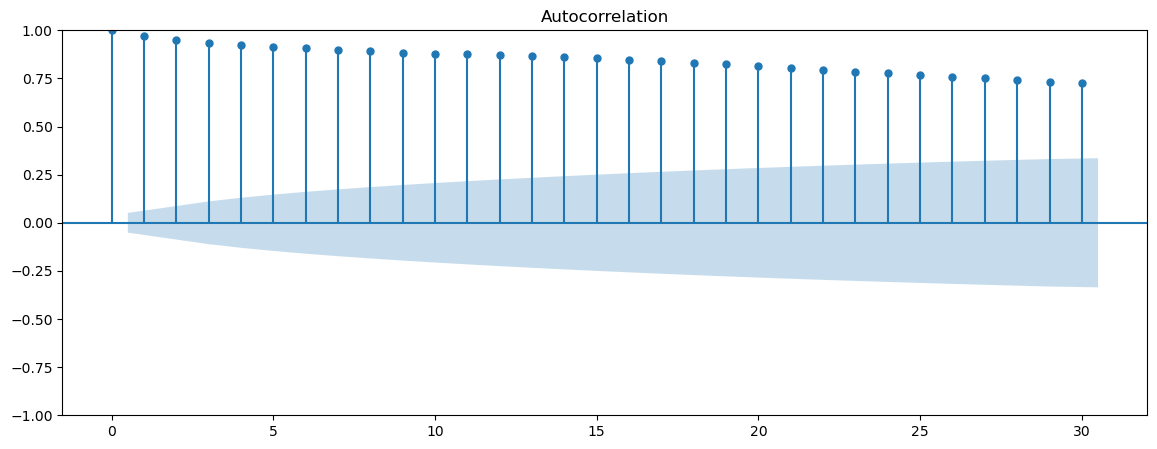

In [35]:
plot_acf(df.temperatura_media.values, lags=30)
plt.show()

#### Visão de 3 Meses

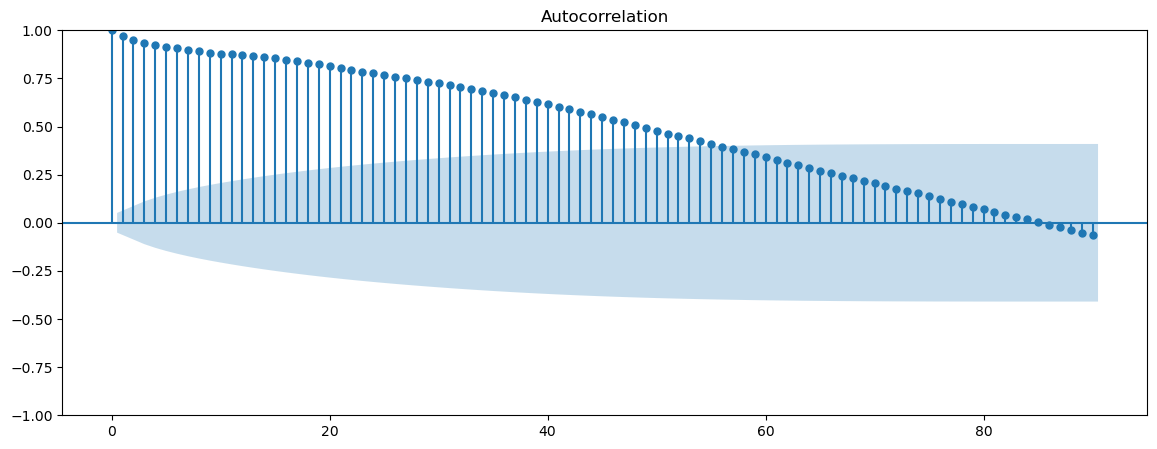

In [36]:
plot_acf(df.temperatura_media.values, lags=90)
plt.show()

#### Visão de 6 Meses

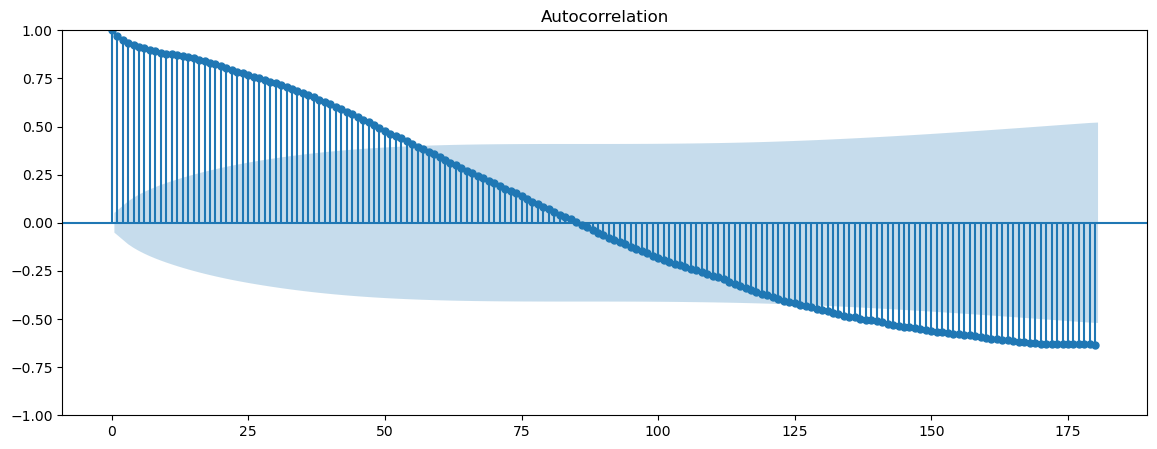

In [37]:
plot_acf(df.temperatura_media.values, lags=180)
plt.show()

#### Visão de 1 Ano

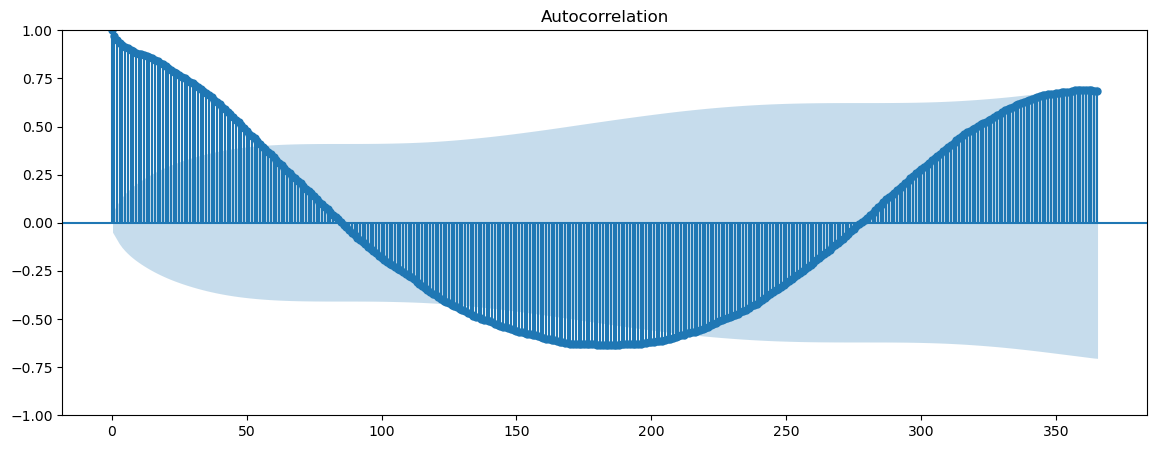

In [38]:
plot_acf(df.temperatura_media.values, lags=365)
plt.show()

#### Visão de 2 anos

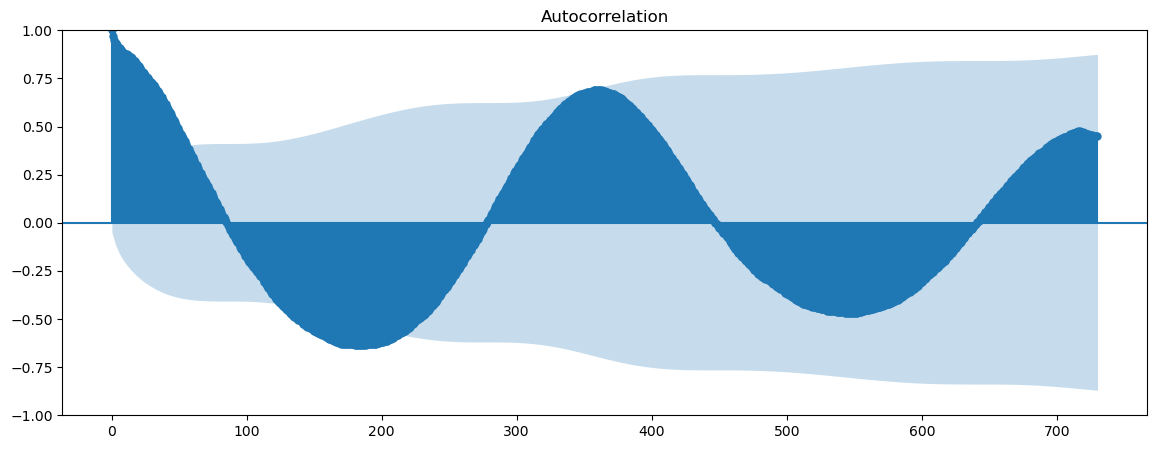

In [39]:
plot_acf(df.temperatura_media.values, lags=730)
plt.show()

#### Visão de 3 anos

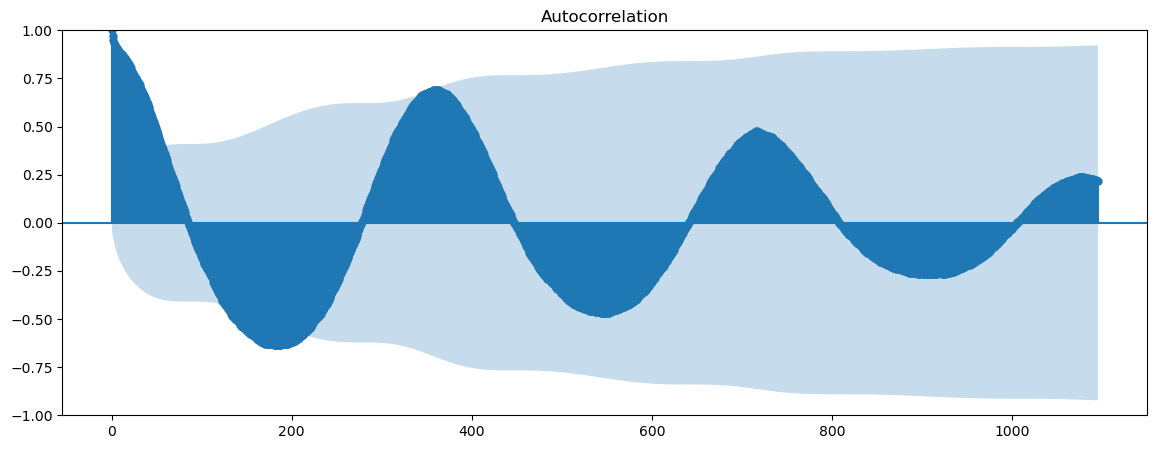

In [40]:
plot_acf(df.temperatura_media.values, lags=1095)
plt.show()

#### Visão com todo os dados de treino

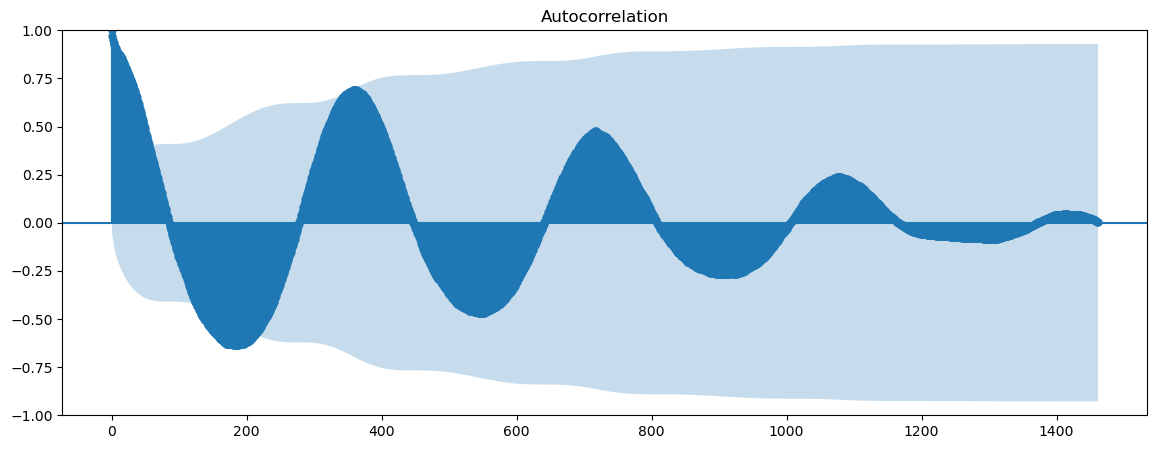

In [41]:
plot_acf(df.temperatura_media.values, lags=1461)
plt.show()

## 6.4 Função de Autocorrelação Parcial (PACF)

- A PACF mede a correlação entre uma série temporal e seus valores defasados, controlando os efeitos de outras defasagens intermediárias.
- Ela ajuda a identificar a relação direta entre um ponto de dados e seus valores defasados, excluindo a influência de outras defasagens.
- Semelhante ao gráfico da ACF, o eixo x representa a defasagem ou o intervalo de tempo, e o eixo y representa o coeficiente de correlação.
- Picos significativos no gráfico da PACF indicam o número de termos defasados a serem incluídos em modelos autorregressivos (AR).
- Interpretar esses gráficos ajuda a identificar possíveis padrões, tendências e sazonalidade nos dados de séries temporais, fornecendo insights para modelagem e previsão.

#### Visão de 1 mês

C:\Users\Gamer\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


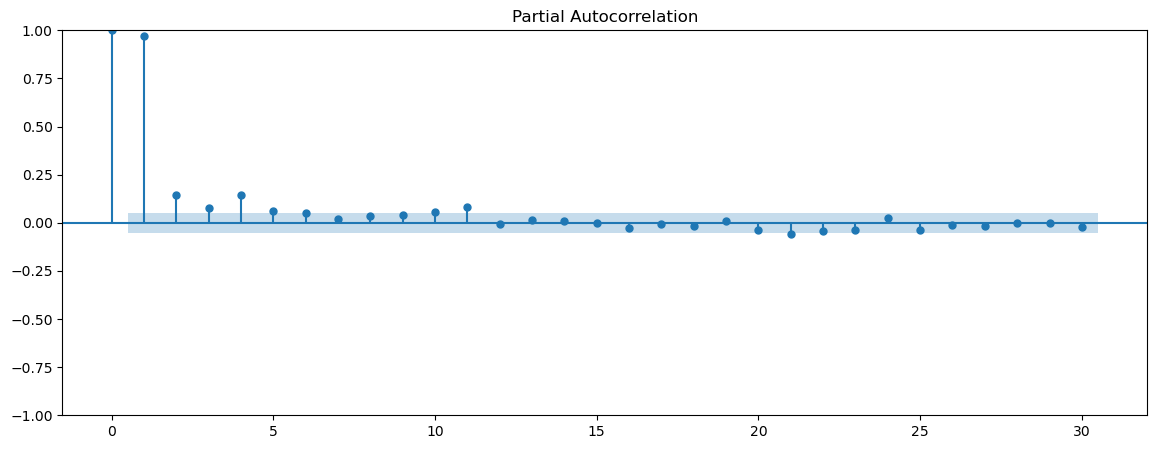

In [42]:
plot_pacf(df.temperatura_media.values, lags=30)
plt.show()

#### Visão de 3 Meses

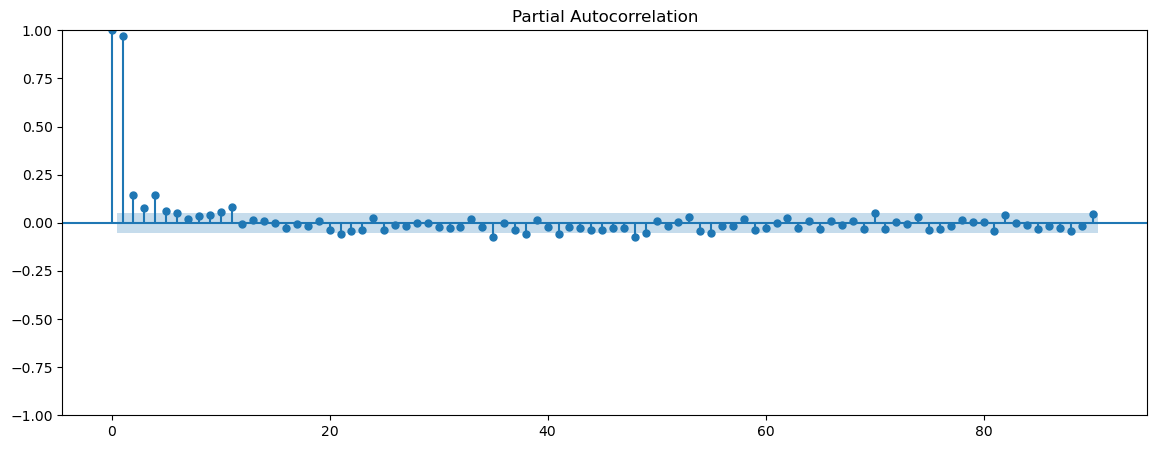

In [43]:
plot_pacf(df.temperatura_media.values, lags=90)
plt.show()

#### Visão de 6 Meses

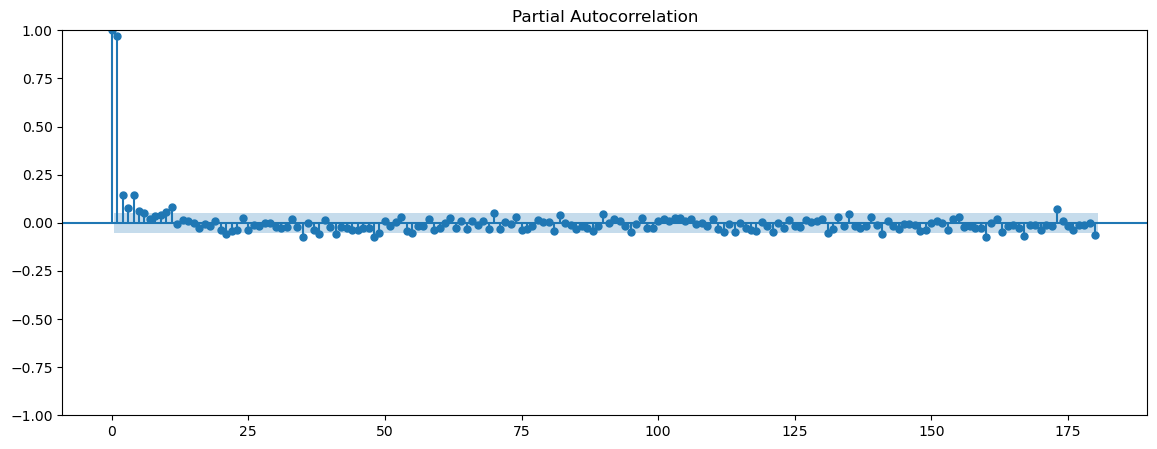

In [44]:
plot_pacf(df.temperatura_media.values, lags=180)
plt.show()

#### Visão de 1 Ano

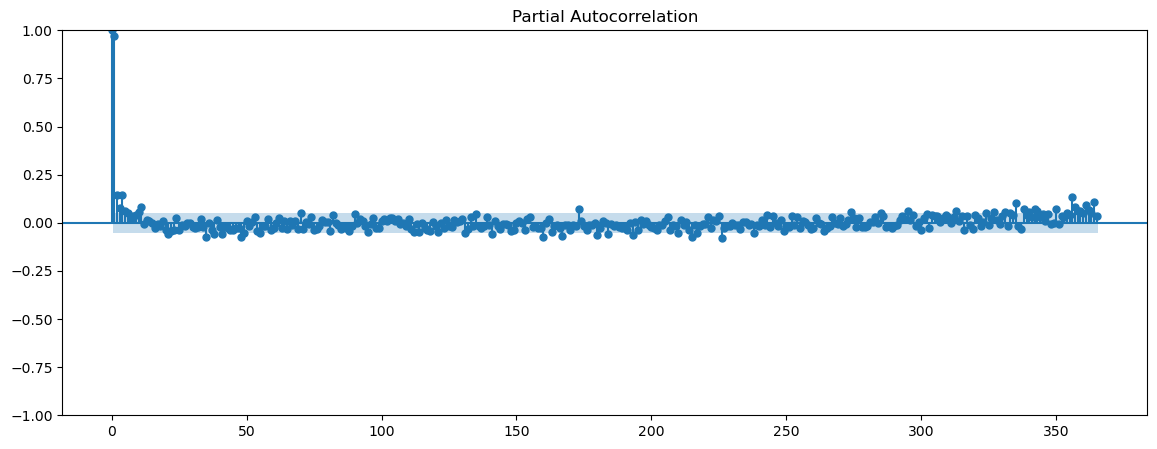

In [45]:
plot_pacf(df.temperatura_media.values, lags=365)
plt.show()

#### Visão de 2 anos

Maior possível, pois usando todos os dados de treino temos que 1461/2 = 730.5

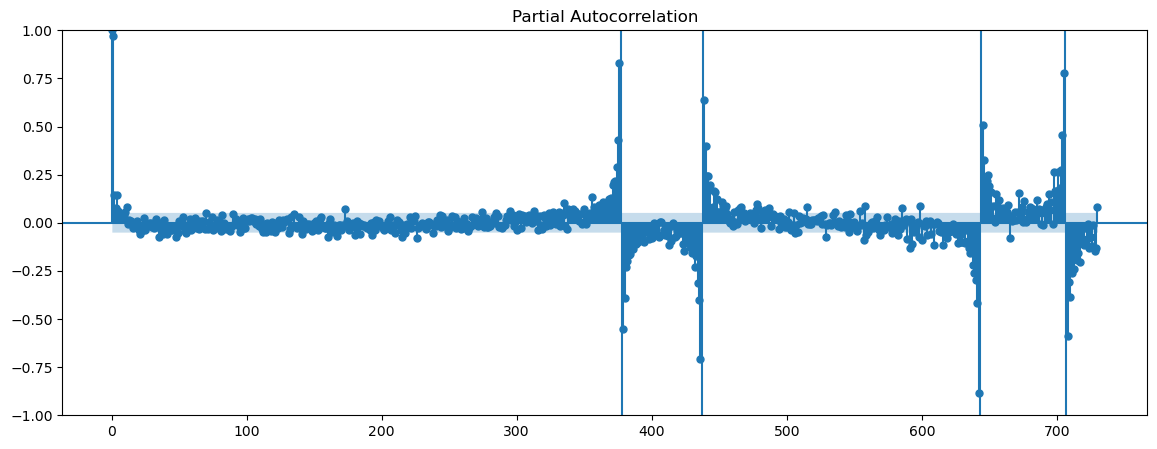

In [46]:
plot_pacf(df.temperatura_media.values, lags=730)
plt.show()

#### Média Móvel Exponencialmente Ponderada

É um tipo de filtro de resposta infinita ao impulso que aplica fatores de ponderação que diminuem exponencialmente. Ele dá mais peso às observações recentes enquanto reduz a influência dos pontos de dados mais antigos. Isso o torna muito útil na análise de séries temporais para suavizar dados, detectar tendências e fazer previsões.

In [47]:
df1 = df.iloc[:365, :]

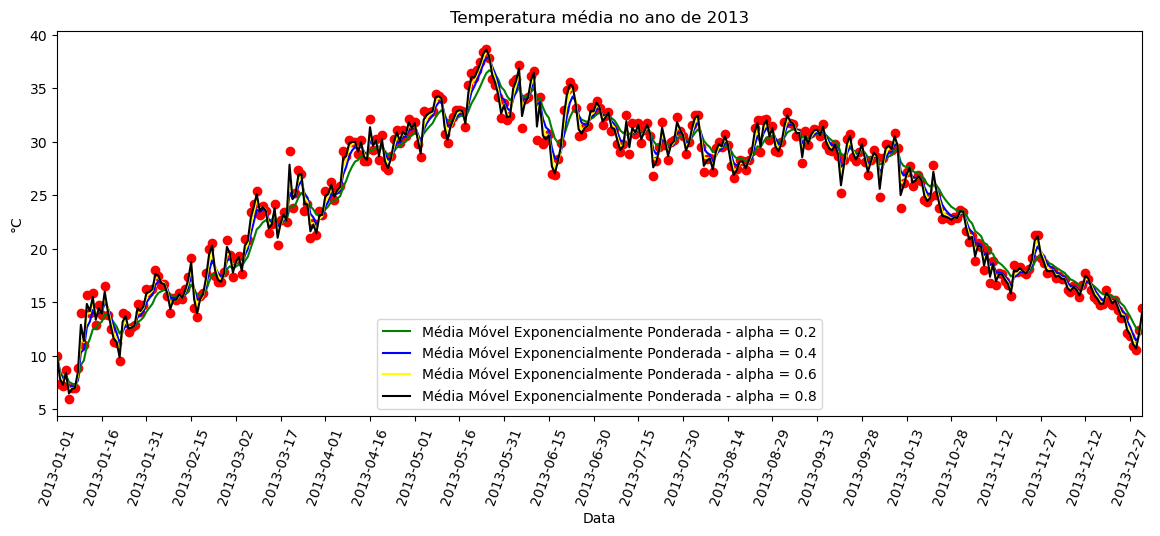

In [48]:
# Definindo as datas do eixo X a cada 15 dias
ticks = []
for i in range(len(df1.index)):
    if i%15 == 0:
        ticks.append(df1.index[i])

# Curvas de médias móveis exponecialmente ponderada
curva1 = df1['temperatura_media'].ewm(alpha=0.2).mean()
curva2 = df1['temperatura_media'].ewm(alpha=0.4).mean()
curva3 = df1['temperatura_media'].ewm(alpha=0.6).mean()
curva4 = df1['temperatura_media'].ewm(alpha=0.8).mean()
# Maiores valores de alpha dão mais peso aos valores mais recentes

plt.title('Temperatura média no ano de 2013')
plt.xlabel('Data')
plt.ylabel('°C')
plt.scatter(df1.index, df1['temperatura_media'], color='red')
plt.plot(df1.index, curva1, color='green', label = 'Média Móvel Exponencialmente Ponderada - alpha = 0.2')
plt.plot(df1.index, curva2, color='blue', label = 'Média Móvel Exponencialmente Ponderada - alpha = 0.4')
plt.plot(df1.index, curva3, color='yellow', label = 'Média Móvel Exponencialmente Ponderada - alpha = 0.6')
plt.plot(df1.index, curva4, color='black', label = 'Média Móvel Exponencialmente Ponderada - alpha = 0.8')
plt.xticks(ticks = ticks, rotation='70')
plt.xlim(df1.index.min(),df1.index.max())
plt.legend()
plt.show()

# 7. Preparação dos Dados

Obtendo dados mensais (Média de cada um dos meses).

In [49]:
m_df = df.resample('M').mean()

Separação dos dados de Treino e Teste:

In [50]:
tamanho_do_treino = int(len(m_df) * 0.7)
treino, teste = m_df.iloc[:tamanho_do_treino], m_df.iloc[tamanho_do_treino:]

# 8. Treinamento dos Modelos

## 8.1 ARIMA-SARIMA-SARIMAX

### Parâmetros "p", "d" e "q"

- p:  
 - p é a ordem do termo Auto Regressivo (AR). Refere-se ao número de defasagens de Y a serem usadas como preditores.

- d:  
 - O termo Auto Regressivo no ARIMA significa que é um modelo de regressão linear que usa suas próprias defasagens como preditores. Modelos de regressão linear, como sabemos, funcionam melhor quando os preditores não são correlacionados e são independentes uns dos outros. Portanto, precisamos tornar a série temporal estacionária.

 - A abordagem mais comum para tornar a série estacionária é diferenciá-la. Ou seja, subtrair o valor anterior do valor atual. Às vezes, dependendo da complexidade da série, mais de uma diferenciação pode ser necessária.

 - O valor de d, portanto, é o número mínimo de diferenciações necessárias para tornar a série estacionária. Se a série temporal já for estacionária, então d = 0.

- q:  
 - q é a ordem do termo de Média Móvel (MA). Refere-se ao número de erros de previsão defasados que devem ser incluídos no modelo ARIMA.


## 8.2 Auto ARIMA

A função auto_arima irá automaticamente buscar combinações desses parâmetros dentro dos intervalos especificados para encontrar o modelo de melhor ajuste com base em critérios como o AIC (Critério de Informação de Akaike). Ao definir esses valores máximos (max_p, max_d, max_q, max_P, max_D, max_Q), você está especificando os limites dentro dos quais o auto_arima fará a busca.

Sazonalizada anual com dados mensais, portanto m, que é a frequência, é igual a 12.

### SARIMA

Modelo ARIMA com Sazonalidade.

In [51]:
modelo = pm.auto_arima(y = treino.temperatura_media,
                       start_p = 0, start_q = 0,
                       start_P = 0, start_Q = 0,
                       max_d = 1, max_p = 8, max_q = 4,
                       max_P=4, max_D=1, max_Q=3,
                       seasonal = True, m=12, test='adf',
                       trace=2, n_jobs=-1, random_state=42, error_action='ignore',
                       n_fits=10, stepwise=False, maxiter=100)


Best model:  ARIMA(2,1,0)(1,1,0)[12]          
Total fit time: 21.443 seconds


In [52]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   34
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 12)   Log Likelihood                 -36.064
Date:                            Tue, 16 Jul 2024   AIC                             80.129
Time:                                    00:45:42   BIC                             84.307
Sample:                                01-31-2013   HQIC                            81.036
                                     - 10-31-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5567      0.333     -1.672      0.095      -1.209       0.096
ar.L2         -0.3829      0.371     -1.033      0.302      -1.109       0.344
ar.S.L12      -0.7807      0.155     -5.041      0.000      -1.084      -0.477
sigma2         1.0369      0.758      1.368      0.171      -0.448       2.522
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.53
Prob(Q):                              0.96   Prob(JB):                         0.77
Heteroskedasticity (H):               0.19   Skew:                             0.37
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

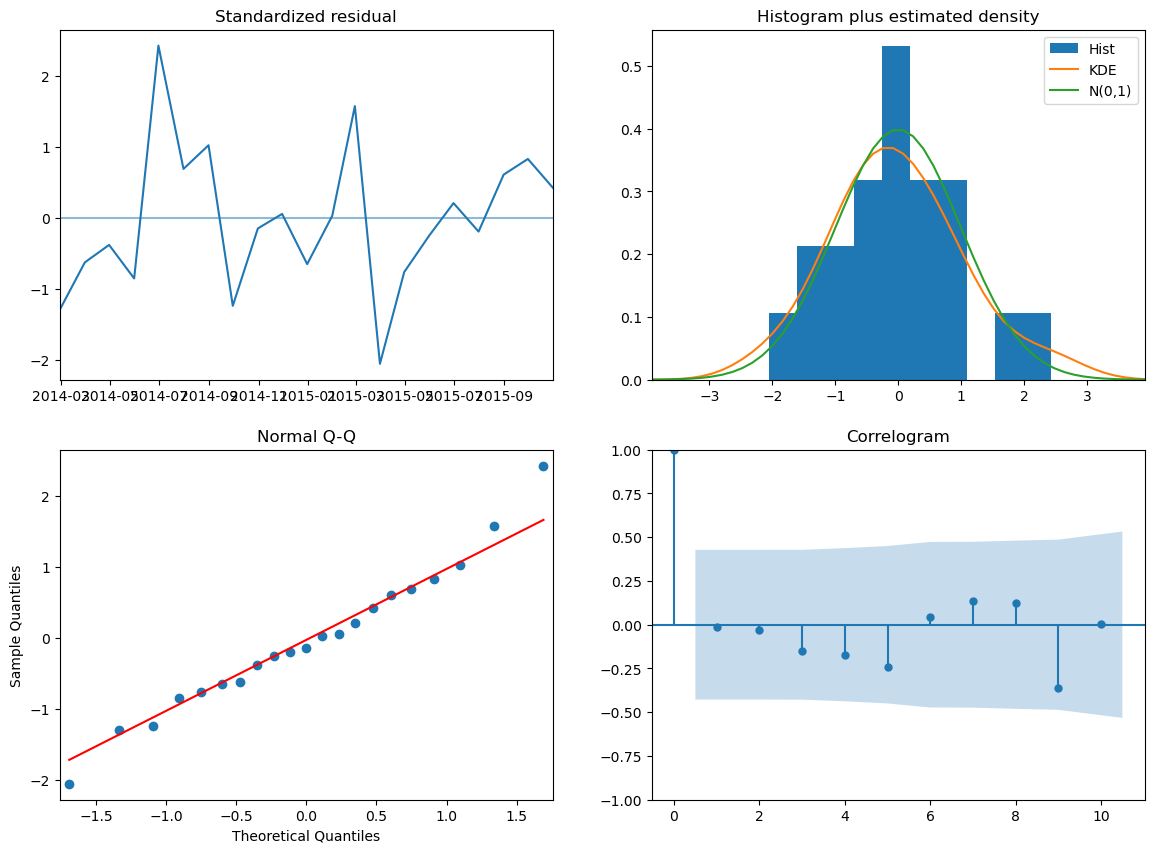

In [53]:
modelo.plot_diagnostics(figsize=(14,10))
plt.show()

In [54]:
n_periodos = len(teste)
auto_arima_pred  = modelo.predict(n_periods=n_periodos)

Métricas de teste:

In [55]:
# Métricas R2, MSE e RMSE
r2 = r2_score(teste.temperatura_media, auto_arima_pred)
mse = mean_squared_error(teste.temperatura_media, auto_arima_pred)
rmse = np.sqrt(mean_squared_error(teste.temperatura_media, auto_arima_pred))

print(f'R2 score: {r2}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print("AIC:", modelo.aic())

R2 score: 0.9257405321408655
MSE: 4.522915840308374
RMSE: 2.1267147999457694
AIC: 80.1287753471729


Previsão do modelo para dados de teste:

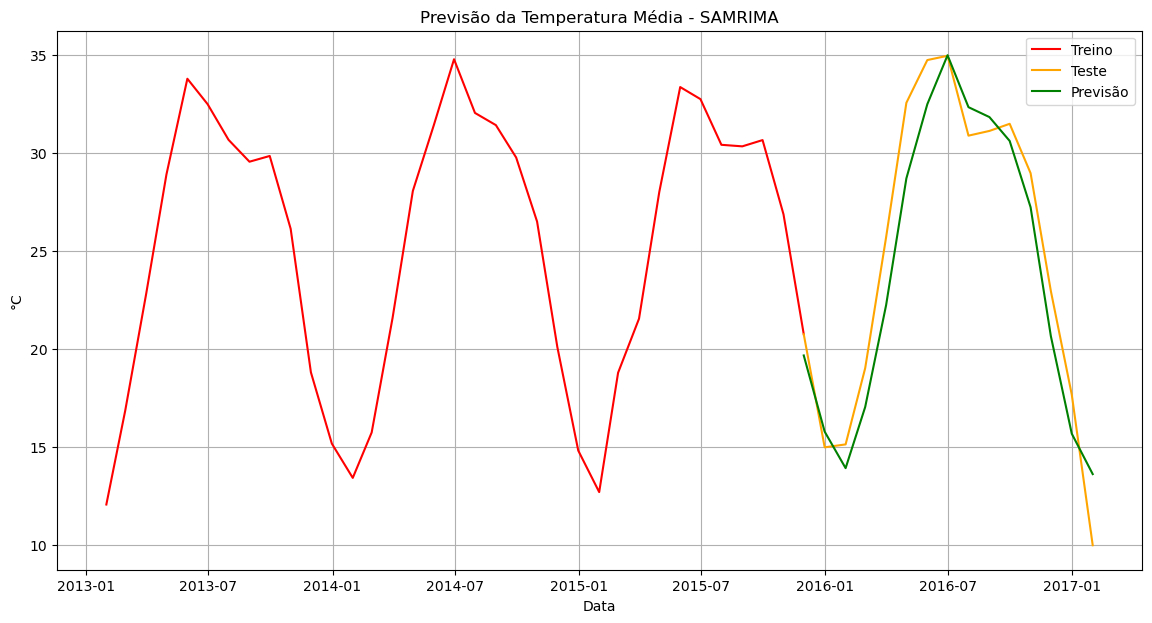

In [56]:
# Ajustando a quebra do gráfico
treino_x = treino.index.tolist()
treino_x.append(teste.index[0])
treino_y = treino.temperatura_media.tolist()
treino_y.append(teste.temperatura_media[0])

plt.figure(figsize=(14, 7))
plt.plot(treino_x, treino_y, label='Treino', color='red')
plt.plot(teste.index, teste.temperatura_media, label='Teste', color= 'orange')
plt.plot(teste.index, auto_arima_pred, label='Previsão', color='green')
plt.legend()
plt.xlabel('Data')
plt.ylabel('°C')
plt.title('Previsão da Temperatura Média - SAMRIMA')
plt.grid(True)
plt.show()

### SARIMAX

Modelo SARIMA com variáveis exógenas.

In [57]:
modelo1 = pm.auto_arima(y = treino.temperatura_media, X=treino[['humidade','velocidade_do_vento','estacao']],
                       start_p = 0, start_q = 0,
                       start_P = 0, start_Q = 0,
                       max_d = 1, max_p = 8, max_q = 4,
                       max_P=4, max_D=1, max_Q=3,
                       seasonal = True, m=12, test='adf',
                       trace=2, n_jobs=-1, random_state=42, error_action='ignore',
                       n_fits=10, stepwise=False, maxiter=100)


Best model:  ARIMA(0,1,1)(2,0,1)[12] intercept
Total fit time: 22.803 seconds


In [58]:
modelo1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   34
Model:             SARIMAX(0, 1, 1)x(2, 0, 1, 12)   Log Likelihood                 -54.399
Date:                            Tue, 16 Jul 2024   AIC                            126.797
Time:                                    00:46:05   BIC                            140.266
Sample:                                01-31-2013   HQIC                           131.329
                                     - 10-31-2015                                         
Covariance Type:                              opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
intercept               0.0001      0.010      0.011      0.991      -0.020       0.020
humidade               -0.0894      0.026     -3.409      0.001      -0.141      -0.038
velocidade_do_vento     0.1303      0.206      0.634      0.526      -0.273       0.533
estacao                 5.3974      0.840      6.428      0.000       3.752       7.043
ma.L1                  -0.9890      0.447     -2.214      0.027      -1.864      -0.114
ar.S.L12                0.0950     37.242      0.003      0.998     -72.898      73.088
ar.S.L24                0.8718     34.192      0.025      0.980     -66.143      67.887
ma.S.L12                0.3392    100.751      0.003      0.997    -197.129     197.807
sigma2                  0.3921     15.377      0.026      0.980     -29.746      30.531
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                 1.54
Prob(Q):                              0.65   Prob(JB):                         0.46
Heteroskedasticity (H):               0.94   Skew:                             0.48
Prob(H) (two-sided):                  0.91   Kurtosis:                         2.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

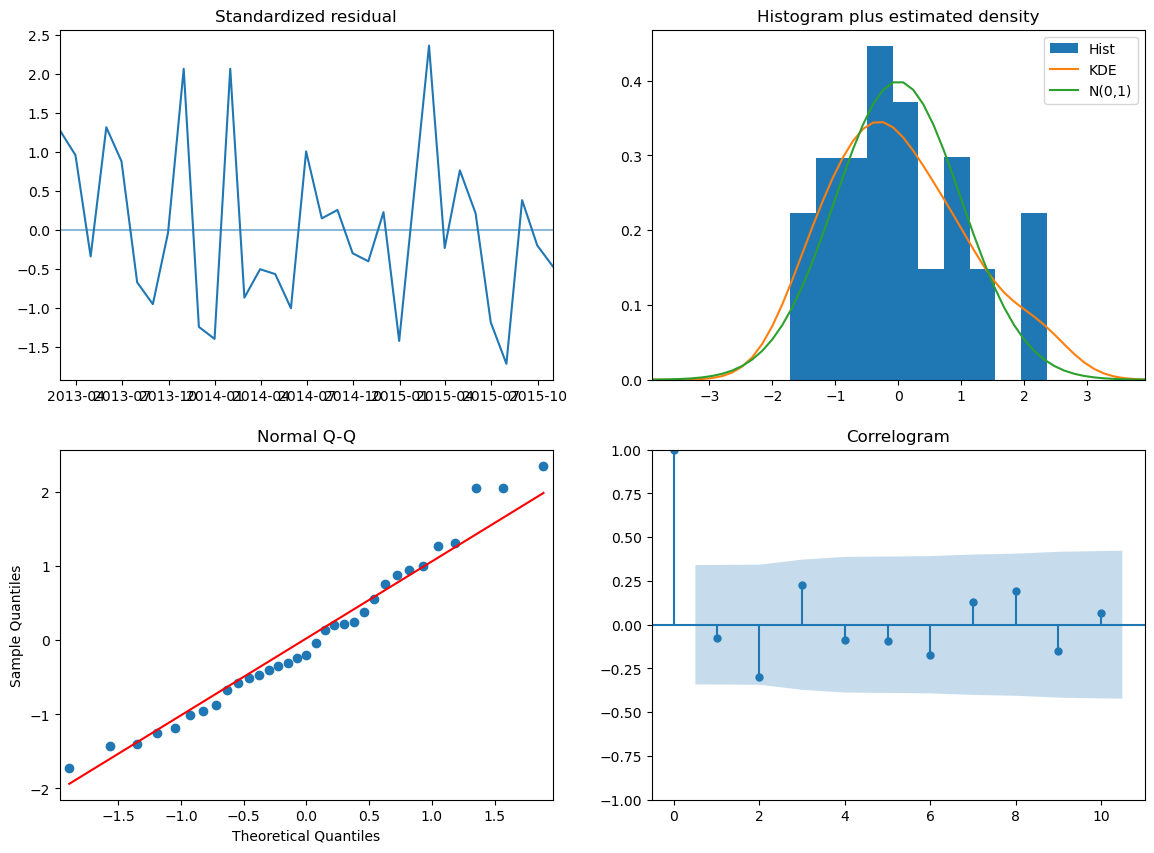

In [59]:
modelo1.plot_diagnostics(figsize=(14,10))
plt.show()

In [60]:
n_periodos = len(teste)
auto_arima_pred  = modelo1.predict(n_periods=n_periodos, X = teste[['humidade','velocidade_do_vento','estacao']])

Métricas de teste:

In [61]:
# Métricas R2, MSE e RMSE
r2 = r2_score(teste.temperatura_media, auto_arima_pred)
mse = mean_squared_error(teste.temperatura_media, auto_arima_pred)
rmse = np.sqrt(mean_squared_error(teste.temperatura_media, auto_arima_pred))

print(f'R2 score: {r2}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print("AIC:", modelo1.aic())

R2 score: 0.9403961394735153
MSE: 3.630287863497095
RMSE: 1.9053314314042833
AIC: 126.79705029554997


Previsão do modelo para dados de teste:

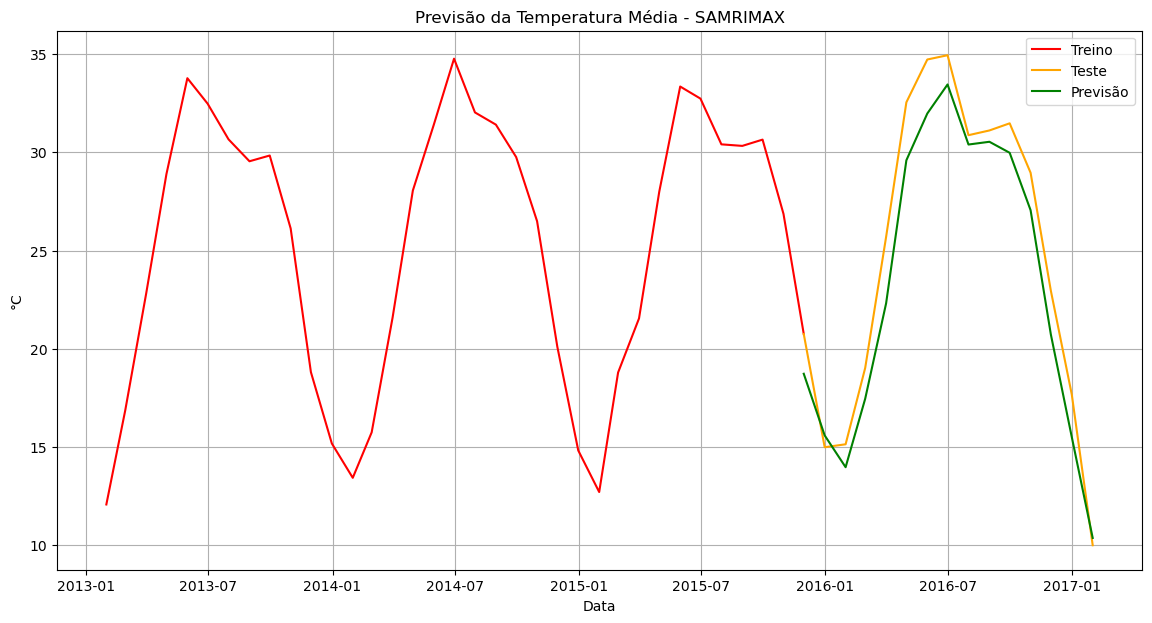

In [62]:
# Ajustando a quebra do gráfico
treino_x = treino.index.tolist()
treino_x.append(teste.index[0])
treino_y = treino.temperatura_media.tolist()
treino_y.append(teste.temperatura_media[0])

plt.figure(figsize=(14, 7))
plt.plot(treino_x, treino_y, label='Treino', color='red')
plt.plot(teste.index, teste.temperatura_media, label='Teste', color= 'orange')
plt.plot(teste.index, auto_arima_pred, label='Previsão', color='green')
plt.legend()
plt.xlabel('Data')
plt.ylabel('°C')
plt.title('Previsão da Temperatura Média - SAMRIMAX')
plt.grid(True)
plt.show()

## 8.3 Prophet

O algoritmo Prophet funciona com as variáveis "ds" e "y" como entradas. Vamos ajustar nossos conjuntos de treinamento e teste de acordo.

- <b> ds: </b> Esta coluna contém as datas. No Prophet, as datas nesta coluna são tipicamente em frequência diária, embora isso não seja obrigatório. As datas podem estar no formato AAAA-MM-DD (por exemplo, "2024-04-01") ou em formato de timestamp.

- <b>y: </b> Esta coluna contém os valores observados que você deseja prever. Por exemplo, se você deseja prever o número diário de visitantes a um site, a coluna "y" conterá esses números de visitantes.

- <b>yhat: </b> Este é o valor principal previsto pelo modelo. Em outras palavras, é o valor que seu modelo prevê que a série temporal terá para um valor específico de "ds" (data).

- <b>yhat_lower e yhat_upper: </b> Esses valores representam o intervalo de incerteza das previsões. O Prophet leva em conta a incerteza ao fazer previsões, estimando com alta confiança que o valor verdadeiro estará dentro desse intervalo. Por exemplo, se yhat_lower for 50 e yhat_upper for 60, isso significa que o modelo prevê com confiança que o valor verdadeiro estará dentro desse intervalo.

#### Sem Features

In [163]:
p_df = df.reset_index().rename(columns={'data': 'ds', 'temperatura_media': 'y'})

In [164]:
tamanho_do_treino = int(len(p_df) * 0.7)
p_treino, p_teste = p_df.iloc[:tamanho_do_treino], p_df.iloc[tamanho_do_treino:]

In [165]:
modelo_p = Prophet()

modelo_p.fit(p_treino)

01:00:59 - cmdstanpy - INFO - Chain [1] start processing
01:00:59 - cmdstanpy - INFO - Chain [1] done processing


In [166]:
futuro = modelo_p.make_future_dataframe(periods=len(p_teste), freq='D')

In [167]:
previsao = prop_model.predict(futuro)

In [168]:
predicao = previsao[['ds', 'yhat']].set_index('ds').loc[p_teste['ds']]

R2 score: 0.8273688780809596
MSE: 9.033568209651305
RMSE: 3.0055894945336936


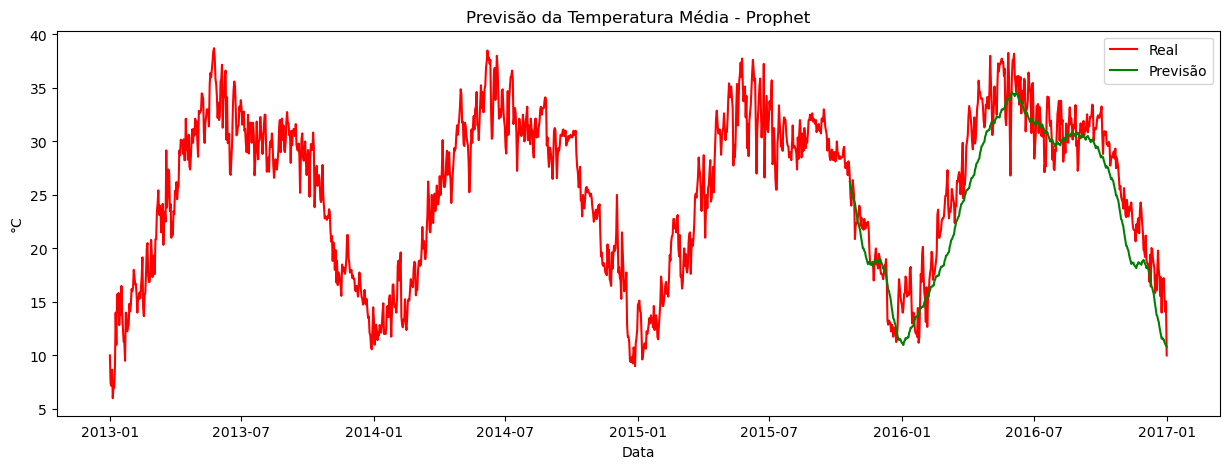

In [169]:
r2 = r2_score(p_teste['y'], predicao['yhat'])
mse = mean_squared_error(p_teste['y'], predicao['yhat'])
rmse = np.sqrt(mean_squared_error(p_teste['y'], predicao['yhat']))

print(f'R2 score: {r2}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

plt.figure(figsize=(15, 5))
plt.plot(p_df['ds'], p_df['y'], color='red', label='Real')
plt.plot(predicao.index, predicao['yhat'], color='green', label='Previsão')
plt.xlabel('Data')
plt.ylabel('°C')
plt.title('Previsão da Temperatura Média - Prophet')
plt.legend()
plt.show()

#### Com Features

In [234]:
p_df = df.reset_index().rename(columns={'data': 'ds', 'temperatura_media': 'y'})

In [235]:
tamanho_do_treino = int(len(p_df) * 0.7)
p_treino, p_teste = p_df.iloc[:tamanho_do_treino], p_df.iloc[tamanho_do_treino:]

In [236]:
modelo_p2 = Prophet()
modelo_p2.add_regressor('humidade')
modelo_p2.add_regressor('velocidade_do_vento')
modelo_p2.add_regressor('estacao')

In [237]:
modelo_p2.fit(p_treino)

01:33:43 - cmdstanpy - INFO - Chain [1] start processing
01:33:43 - cmdstanpy - INFO - Chain [1] done processing


In [238]:
futuro = modelo_p2.make_future_dataframe(periods=len(p_teste), freq='D')

In [240]:
futuro['humidade'] = df['humidade'].values
futuro['velocidade_do_vento'] = df['velocidade_do_vento'].values
futuro['estacao'] = df['estacao'].values

In [176]:
previsao = modelo_p2.predict(futuro)

In [177]:
predicao = previsao[['ds', 'yhat']].set_index('ds').loc[p_teste['ds']]

R2 score: 0.8838047286629989
MSE: 6.080351547237258
RMSE: 2.46583688577271


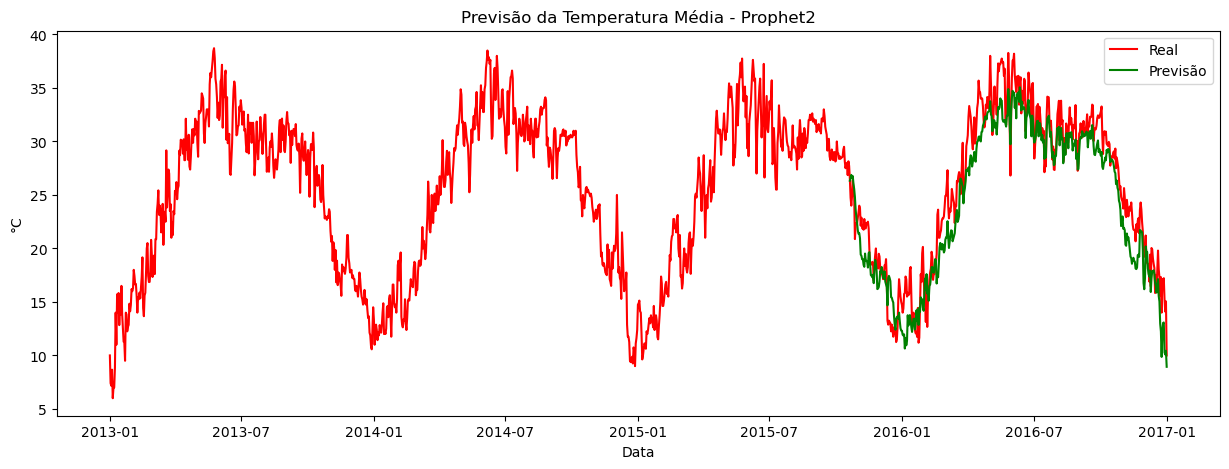

In [178]:
r2 = r2_score(p_teste['y'], predicao['yhat'])
mse = mean_squared_error(p_teste['y'], predicao['yhat'])
rmse = np.sqrt(mean_squared_error(p_teste['y'], predicao['yhat']))

print(f'R2 score: {r2}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

plt.figure(figsize=(15, 5))
plt.plot(p_df['ds'], p_df['y'], color='red', label='Real')
plt.plot(predicao.index, predicao['yhat'], color='green', label='Previsão')
plt.xlabel('Data')
plt.ylabel('°C')
plt.title('Previsão da Temperatura Média - Prophet2')
plt.legend()
plt.show()

# 9. Teste e Projeções dos Modelos

## 9.1 SARIMA

In [197]:
n_periodos = len(df_teste)
sarima_pred  = modelo.predict(n_periods=n_periodos)

R2 score: -1.6613542562171055
MSE: 106.70882153678936
RMSE: 10.329996202167228
AIC: 80.1287753471729


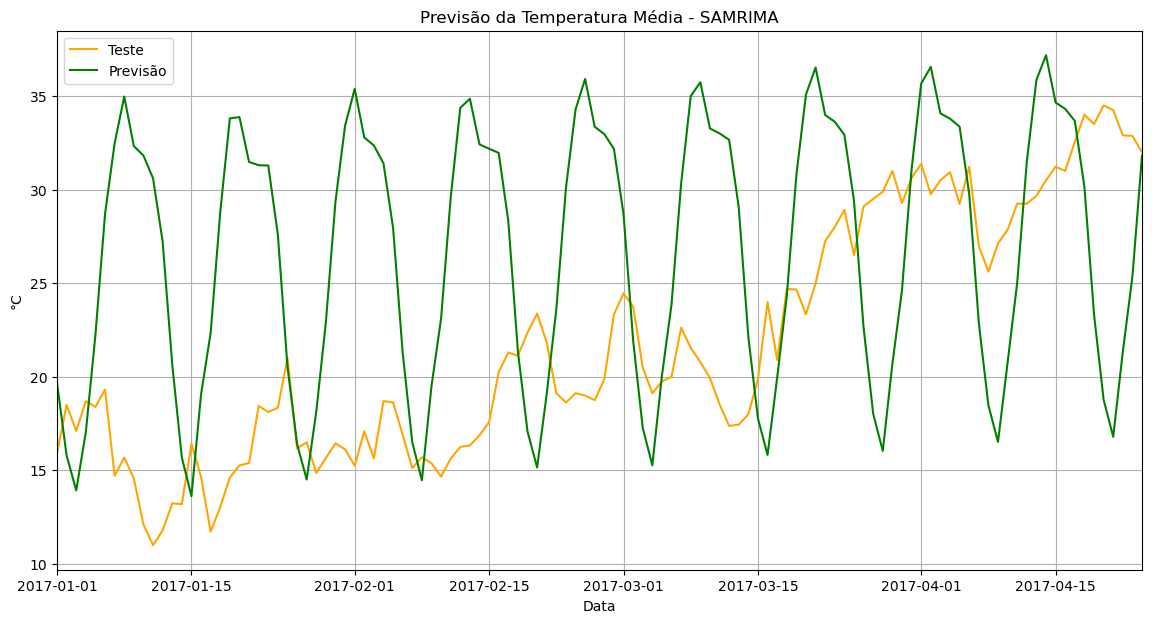

In [218]:
r2 = r2_score(df_teste.temperatura_media, sarima_pred)
mse = mean_squared_error(df_teste.temperatura_media, sarima_pred)
rmse = np.sqrt(mean_squared_error(df_teste.temperatura_media, sarima_pred))

print(f'R2 score: {r2}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print("AIC:", modelo.aic())

plt.figure(figsize=(14, 7))
plt.plot(df_teste.index, df_teste.temperatura_media, label='Teste', color= 'orange')
plt.plot(df_teste.index, sarima_pred, label='Previsão', color='green')
plt.legend()
plt.xlabel('Data')
plt.ylabel('°C')
plt.title('Previsão da Temperatura Média - SAMRIMA')
plt.xlim(df_teste.index.min(), df_teste.index.max())
plt.grid(True)
plt.show()

## 9.2 SARIMAX

In [199]:
n_periodos = len(df_teste)
sarimax_pred  = modelo1.predict(n_periods=n_periodos, X = df_teste[['humidade','velocidade_do_vento','estacao']])

R2 score: 0.6620745043174172
MSE: 13.549354178342114
RMSE: 3.6809447399196467
AIC: 80.1287753471729


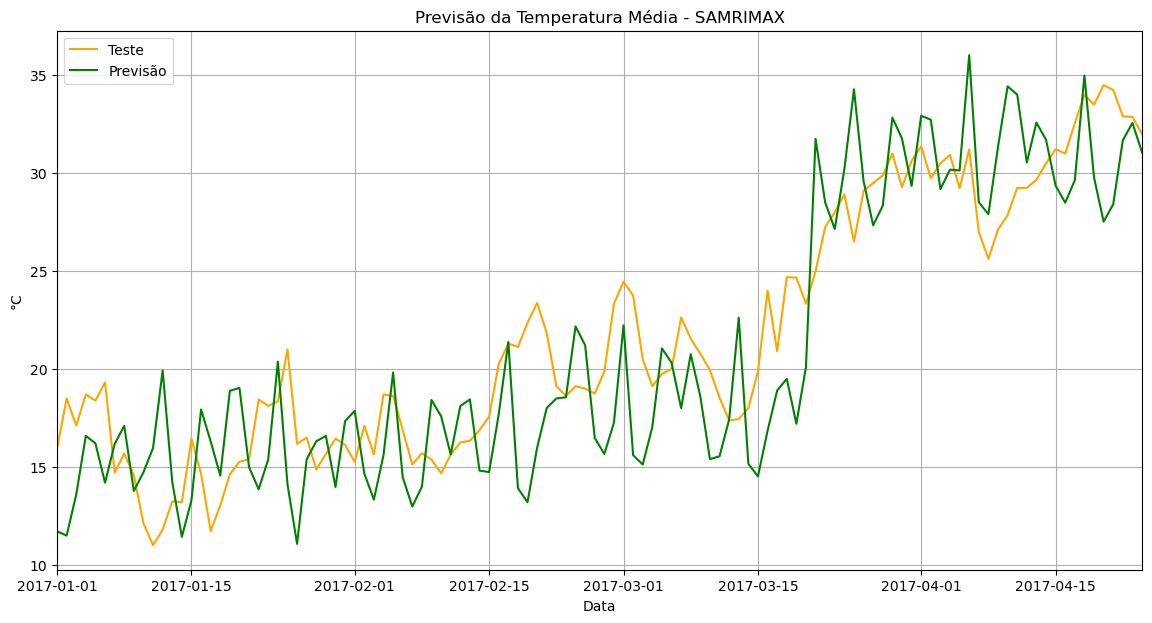

In [219]:
r2 = r2_score(df_teste.temperatura_media, sarimax_pred)
mse = mean_squared_error(df_teste.temperatura_media, sarimax_pred)
rmse = np.sqrt(mean_squared_error(df_teste.temperatura_media, sarimax_pred))

print(f'R2 score: {r2}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print("AIC:", modelo.aic())

plt.figure(figsize=(14, 7))
plt.plot(df_teste.index, df_teste.temperatura_media, label='Teste', color= 'orange')
plt.plot(df_teste.index, sarimax_pred, label='Previsão', color='green')
plt.legend()
plt.xlabel('Data')
plt.ylabel('°C')
plt.title('Previsão da Temperatura Média - SAMRIMAX')
plt.xlim(df_teste.index.min(), df_teste.index.max())
plt.grid(True)
plt.show()

## 9.3 Prophet

#### Sem Features

In [226]:
p_df_teste = df_teste.reset_index().rename(columns={'data': 'ds', 'temperatura_media': 'y'})

In [242]:
previsao = modelo_p.predict(p_df_teste[['ds', 'y']])

In [243]:
predicao = previsao[['ds', 'yhat']].set_index('ds').loc[p_df_teste['ds']]

R2 score: 0.7987644385966857
MSE: 8.06867765104103
RMSE: 2.8405417882933937


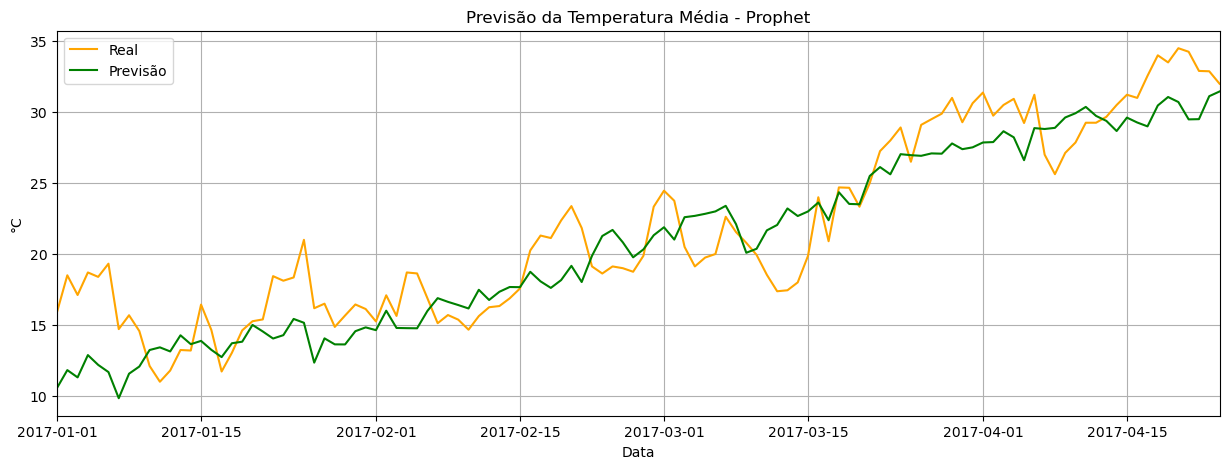

In [251]:
r2 = r2_score(p_df_teste['y'], predicao['yhat'])
mse = mean_squared_error(p_df_teste['y'], predicao['yhat'])
rmse = np.sqrt(mean_squared_error(p_df_teste['y'], predicao['yhat']))

print(f'R2 score: {r2}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

plt.figure(figsize=(15, 5))
plt.plot(p_df_teste['ds'], p_df_teste['y'], color='orange', label='Real')
plt.plot(predicao.index, predicao['yhat'], color='green', label='Previsão')
plt.xlabel('Data')
plt.ylabel('°C')
plt.title('Previsão da Temperatura Média - Prophet')
plt.xlim(df_teste.index.min(), df_teste.index.max())
plt.legend()
plt.grid(True)
plt.show()

#### Com Features

In [246]:
p_df_teste = df_teste.reset_index().rename(columns={'data': 'ds', 'temperatura_media': 'y'})

In [248]:
previsao = modelo_p2.predict(p_df_teste)

In [249]:
predicao = previsao[['ds', 'yhat']].set_index('ds').loc[p_df_teste['ds']]

R2 score: 0.7987644385966857
MSE: 8.06867765104103
RMSE: 2.8405417882933937


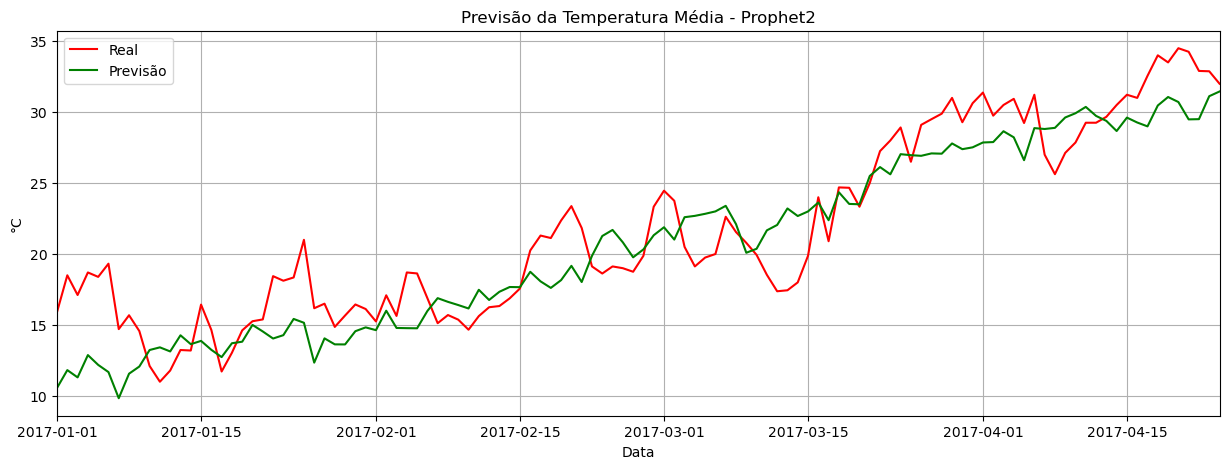

In [252]:
r2 = r2_score(p_df_teste['y'], predicao['yhat'])
mse = mean_squared_error(p_df_teste['y'], predicao['yhat'])
rmse = np.sqrt(mean_squared_error(p_df_teste['y'], predicao['yhat']))

print(f'R2 score: {r2}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

plt.figure(figsize=(15, 5))
plt.plot(p_df_teste['ds'], p_df_teste['y'], color='red', label='Real')
plt.plot(predicao.index, predicao['yhat'], color='green', label='Previsão')
plt.xlabel('Data')
plt.ylabel('°C')
plt.title('Previsão da Temperatura Média - Prophet2')
plt.xlim(df_teste.index.min(), df_teste.index.max())
plt.legend()
plt.grid(True)
plt.show()

# 10. Conclusão